# On the Effect of Coreset Selection in Variational Continual Learning

In [ ]:
#@title Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.optim import SGD
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#@title Dataset Definition
# Code adapted from https://github.com/Piyush-555/VCL-in-PyTorch/blob/main/dataset.py


################## SplitMNIST ##################
def _extract_class_specific_idx(dataset, target_classes):
    """
    dataset: torchvision.datasets.MNIST
    target_classes: list
    """
    idx = torch.zeros_like(dataset.targets, dtype=torch.bool)
    for target in target_classes:
        idx = idx | (dataset.targets==target)

    return idx


def get_split_dataloaders(class_distribution, batch_size=256, sample_ratio=1.0):
    """
    class_distribution: list[list]
    """
    rsz = 28
    transform = transforms.Compose([
        transforms.Resize((rsz, rsz)),
        transforms.ToTensor(),
    ])

    dataset = torchvision.datasets.MNIST
    trainset = dataset(root="./data", train=True, download=True, transform=transform)
    testset = dataset(root="./data", train=False, download=True, transform=transform)

    dataloaders = []

    for classes in class_distribution:
        train_idx = _extract_class_specific_idx(trainset, classes)
        train_idx = torch.where(train_idx)[0]
        train_size = train_idx.size()[0]
        train_idx = train_idx[:int(train_size * sample_ratio)]
        print(f'Sampling {int(train_size * sample_ratio)} samples out of {train_size} for training on task {classes}')
        sub_train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        sub_train_loader = torch.utils.data.DataLoader(
            trainset, batch_size=batch_size, sampler=sub_train_sampler)

        test_idx = _extract_class_specific_idx(testset, classes)
        test_idx = torch.where(test_idx)[0]
        test_size = test_idx.size()[0]
        test_idx = test_idx[:int(test_size * sample_ratio)]
        print(f'Sampling {int(test_size * sample_ratio)} samples out of {test_size} for testing on task {classes}')
        sub_test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)
        sub_test_loader = torch.utils.data.DataLoader(
            testset, batch_size=batch_size, sampler=sub_test_sampler)

        dataloaders.append((sub_train_loader, sub_test_loader))

    return dataloaders


################## PermutedMNIST ##################
def get_permuted_dataloaders(num_tasks, batch_size=256):
    dataset = torchvision.datasets.MNIST
    dataloaders = []

    for task in range(num_tasks):
        if task == 0:
            transform = transforms.Compose([
                transforms.Resize((28, 28)),
                transforms.ToTensor()
            ])
        else:
            rng_permute = np.random.RandomState(task)
            idx_permute = torch.from_numpy(rng_permute.permutation(784))
            transform = transforms.Compose([
                transforms.Resize((28, 28)),
                transforms.ToTensor(),
                transforms.Lambda(lambda x, idx=idx_permute: x.view(-1)[idx].view(1, 28, 28))
            ])

        sub_trainset = dataset(root="./data", train=True, download=True, transform=transform)
        sub_train_sampler = torch.utils.data.RandomSampler(sub_trainset)
        sub_train_loader = torch.utils.data.DataLoader(
            sub_trainset, batch_size=batch_size, sampler=sub_train_sampler)

        sub_testset = dataset(root="./data", train=False, download=True, transform=transform)
        sub_test_sampler = torch.utils.data.RandomSampler(sub_testset)
        sub_test_loader = torch.utils.data.DataLoader(
            sub_testset, batch_size=batch_size, sampler=sub_test_sampler)

        dataloaders.append((sub_train_loader, sub_test_loader))

    return dataloaders


def get_joint_permuted_dataloaders(num_tasks, batch_size=256):
    dataset = torchvision.datasets.MNIST
    dataloaders = []
    transforms_list = []

    for task in range(num_tasks):
        if task == 0:
            transform = transforms.Compose([
                transforms.Resize((28, 28)),
                transforms.ToTensor()
            ])
        else:
            rng_permute = np.random.RandomState(task)
            idx_permute = torch.from_numpy(rng_permute.permutation(784))
            transform = transforms.Compose([
                transforms.Resize((28, 28)),
                transforms.ToTensor(),
                transforms.Lambda(lambda x, idx=idx_permute: x.view(-1)[idx].view(1, 28, 28))
            ])
        transforms_list.append(transform)

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset(
            [dataset(root="./data", train=True, download=True, transform=transforms_list[i]) for i in range(num_tasks)]
            ),
            batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset(
            [dataset(root="./data", train=False, download=True, transform=transforms_list[i]) for i in range(num_tasks)]
            ),
            batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

In [ ]:
#@title Layer Definition
# Adapted from https://github.com/Piyush-555/VCL-in-PyTorch/blob/main/layers/BBBLinear.py


def KL_DIV(mu_p, sig_p, mu_q, sig_q):
    kl = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()
    return kl


class BBBLinear(nn.Module):

    def __init__(self, in_features, out_features, bias=True, priors=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = bias

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.01,
            }
        self.prior_W_mu = torch.tensor(priors['prior_mu'])
        self.prior_W_sigma = torch.tensor(priors['prior_sigma'])
        self.prior_bias_mu = torch.tensor(priors['prior_mu'])
        self.prior_bias_sigma = torch.tensor(priors['prior_sigma'])

        self.W_mu = Parameter(torch.Tensor(out_features, in_features))
        self.W_rho = Parameter(torch.Tensor(out_features, in_features))
        if self.use_bias:
            self.bias_mu = Parameter(torch.Tensor(out_features))
            self.bias_rho = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(0, 0.1)
        self.W_rho.data.fill_(-3)

        if self.use_bias:
            self.bias_mu.data.normal_(0, 0.1)
            self.bias_rho.data.fill_(-3)

    def forward(self, x, sample=True):
        self.W_sigma = torch.log1p(torch.exp(self.W_rho))
        if self.use_bias:
            self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
            bias_var = self.bias_sigma ** 2
        else:
            self.bias_sigma = bias_var = None

        act_mu = F.linear(x, self.W_mu, self.bias_mu)
        act_var = 1e-16 + F.linear(x ** 2, self.W_sigma ** 2, bias_var)
        act_std = torch.sqrt(act_var)

        if self.training or sample:
            eps = torch.empty(act_mu.size()).normal_(0, 1).to(act_mu.device)
            return act_mu + act_std * eps
        else:
            return act_mu

    def kl_loss(self):
        kl = KL_DIV(self.prior_W_mu, self.prior_W_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            kl += KL_DIV(self.prior_bias_mu, self.prior_bias_sigma, self.bias_mu, self.bias_sigma)
        return kl

In [ ]:
#@title Model Definition
# Adapted from https://github.com/Piyush-555/VCL-in-PyTorch/blob/main/models/split_model.py

class SplitModel(nn.Module):

    def __init__(self):
        """
        input: 1 x 28 x 28
        output: 5 classifiers 2 nodes each
        hidden: [256, 256]
        """
        super().__init__()
        self.fc1 = BBBLinear(784, 256)
        self.fc2 = BBBLinear(256, 256)
        self.classifiers = nn.ModuleList([BBBLinear(256, 2) for i in range(5)])

    def forward(self, x, task_id, sample=True):
        out = x.view(-1, 784)
        for layer in self.children():
            if layer.__class__ is not nn.ModuleList:
                out = F.relu(layer(out, sample=sample))
        return self.classifiers[task_id](out)

    def get_kl(self, task_id):
        kl = 0.0
        for layer in self.children():
            if layer.__class__ is not nn.ModuleList:
                kl += layer.kl_loss()
        kl += self.classifiers[task_id].kl_loss()
        return kl

    def update_prior(self):
        for layer in self.children():
            if layer.__class__ is not nn.ModuleList:
                layer.prior_W_mu = layer.W_mu.data
                layer.prior_W_sigma = layer.W_sigma.data
                if layer.use_bias:
                    layer.prior_bias_mu = layer.bias_mu.data
                    layer.prior_bias_sigma = layer.bias_sigma.data

In [ ]:
#@title VCL Method
# Adapted from https://github.com/Piyush-555/VCL-in-PyTorch/blob/main/vcl.py

class ELBO(nn.Module):

    def __init__(self, model, train_size, beta):
        super().__init__()
        self.num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        self.beta = beta
        self.train_size = train_size

    def forward(self, outputs, targets, kl):
        assert not targets.requires_grad
        return F.nll_loss(outputs, targets, reduction='mean') + self.beta * kl / self.num_params


def calculate_accuracy(outputs, targets):
    return np.mean(outputs.argmax(dim=-1).cpu().numpy() == targets.cpu().numpy())


def train(model, num_epochs, dataloader, single_head, task_id, beta, T=10, replay=False):
    beta = 0 if replay else beta
    lr_start = 1e-3

    if single_head:
        offset = 0
        output_nodes = 10
    else:
        output_nodes = model.classifiers[0].out_features
        offset = task_id * output_nodes

    train_size = len(dataloader.dataset) if single_head else dataloader.sampler.indices.shape[0]
    elbo = ELBO(model, train_size, beta)
    optimizer = SGD(model.parameters(), lr=lr_start, momentum=0.9)

    model.train()
    for epoch in tqdm(range(num_epochs)):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)
            targets -= offset
            outputs = torch.zeros(inputs.shape[0], output_nodes, T, device=device)

            for i in range(T):
                net_out = model(inputs, task_id)
                outputs[:, :, i] = F.log_softmax(net_out, dim=-1)

            log_output = torch.logsumexp(outputs, dim=-1) - np.log(T)
            kl = model.get_kl(task_id)
            loss = elbo(log_output, targets, kl)
            loss.backward()
            optimizer.step()


def predict(model, dataloader, single_head, task_id, T=10):
    if single_head:
        offset = 0
        output_nodes = 10
    else:
        output_nodes = model.classifiers[0].out_features
        offset = task_id * output_nodes

    model.train()
    accs = []
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets -= offset
        outputs = torch.zeros(inputs.shape[0], output_nodes, T, device=device)

        for i in range(T):
            with torch.no_grad():
                net_out = model(inputs, task_id)
            outputs[:, :, i] = F.log_softmax(net_out, dim=-1)

        log_output = torch.logsumexp(outputs, dim=-1) - np.log(T)
        accs.append(calculate_accuracy(log_output, targets))

    return np.mean(accs)


def run_vcl(num_tasks, single_head, num_epochs, dataloaders, model,
            coreset_method, coreset_size=0, beta=1, update_prior=True):

    if not single_head:
        assert 10 // num_tasks == 10 / num_tasks

    coreset_list = []
    all_accs = np.empty(shape=(num_tasks, num_tasks))
    all_accs.fill(np.nan)
    for task_id in range(num_tasks):
        print("Starting Task", task_id + 1)
        if single_head:
            offset = 0
        else:
            offset = task_id * 10 // num_tasks

        trainloader, testloader = dataloaders[task_id]

        # UPDATED select coreset before training -> only train on non-coreset data
        # Attach a new coreset
        if coreset_size > 0:
            coreset_method(coreset_list, trainloader, task_id=task_id, num_samples=coreset_size)

        # Train on non-coreset data
        train(model, num_epochs, trainloader, single_head, task_id, beta)
        print(f'Done Training Task {task_id + 1}\n')

        if coreset_size > 0:
            # Replay old tasks using coresets
            for task in range(task_id + 1):
                print(f'Replaying Task {task + 1}')
                train(model, num_epochs, coreset_list[task], single_head, task, beta, replay=True)

        # Evaluate on all tasks (updated from only evaluating on tasks, that have been already trained on)
        for task in range(num_tasks):
            _, testloader_i = dataloaders[task]
            accuracy = predict(model, testloader_i, single_head, task)
            print(f'Task {task + 1} Accuracy: {accuracy}')
            all_accs[task_id][task] = accuracy
        print()
        if update_prior:
            model.update_prior()
    print(all_accs)
    return all_accs

In [ ]:
#@title Select a random coreset
def random_coreset(coresets, sub_train_loader, num_samples=200, task_id=None):
    """
    coresets: list of collection of coreset dataloaders
    sub_train_loader: loader from which a random coreset is to be drawn
    num_samples: number of samples in each coreset
    """
    task_indices = sub_train_loader.sampler.indices
    shuffled_task_indices = task_indices[torch.randperm(len(task_indices))]
    coreset_indices = shuffled_task_indices[:num_samples]
    sub_train_loader.sampler.indices = shuffled_task_indices[num_samples:]  # Delete coreset from orginal data
    coreset_sampler = torch.utils.data.SubsetRandomSampler(coreset_indices)
    coreset_loader = torch.utils.data.DataLoader(
        sub_train_loader.dataset, batch_size=sub_train_loader.batch_size, sampler=coreset_sampler)
    coresets.append(coreset_loader)

In [ ]:
#@title Select a coreset that only contains samples from one label
def one_class(coresets, sub_train_loader, num_samples=200, task_id=None):
    """
    coresets: list of collection of coreset dataloaders
    sub_train_loader: loader from which a coreset is to be drawn
    num_samples: number of samples in each coreset
    """
    task_indices = sub_train_loader.sampler.indices
    # Select one target class at random
    _, target = sub_train_loader.dataset[task_indices[0]]

     # Retrieve indices for samples with the specified target class
    indices_for_target = (sub_train_loader.dataset.targets == target)
    task_indices_bool = torch.zeros(len(sub_train_loader.dataset))
    task_indices_bool[task_indices] = 1

    # Get indices for samples belonging to the specified target class
    task_indices_for_target = torch.logical_and(task_indices_bool, indices_for_target)
    # Get indices for samples not belonging to the specified target class
    task_indices_not_for_target = torch.logical_xor(task_indices_bool, task_indices_for_target)

    # Convert back to indices
    task_indices_for_target = task_indices_for_target.nonzero(as_tuple=True)[0]
    task_indices_not_for_target = task_indices_not_for_target.nonzero(as_tuple=True)[0]

    # Concatenate indices for the specified target class and other classes
    reordered_task_indices = torch.cat((task_indices_for_target, task_indices_not_for_target))
    assert reordered_task_indices.shape == task_indices.shape, f'Mismatch in shape between reordered_task_indices: {reordered_task_indices.shape} and task_indices {task_indices.shape}'

    # Select indices for coreset
    coreset_indices = reordered_task_indices[:num_samples]

    # Remove coreset samples from original data
    sub_train_loader.sampler.indices = reordered_task_indices[num_samples:]

    # Create DataLoader for coreset
    coreset_sampler = torch.utils.data.SubsetRandomSampler(coreset_indices)
    coreset_loader = torch.utils.data.DataLoader(
        sub_train_loader.dataset, batch_size=sub_train_loader.batch_size, sampler=coreset_sampler)

    # Append coreset DataLoader to the list of coresets
    coresets.append(coreset_loader)

In [ ]:
#@title Select samples that another model trained on the set is relatively uncertain about
class DummyModel(nn.Module):

    def __init__(self):
        """
        input: 1 x 28 x 28
        output: 1 classifiers with 10 nodes
        hidden: [100, 100]
        """
        super().__init__()
        self.fc1 = BBBLinear(784, 100)
        self.fc2 = BBBLinear(100, 100)
        self.classifier = BBBLinear(100, 10)

    def forward(self, x, task_id, sample=True):
        out = x.view(-1, 784)
        out = F.relu(self.fc1(out, sample=sample))
        out = F.relu(self.fc2(out, sample=sample))
        return self.classifier(out, sample=sample)

    def get_kl(self, *args):
      return 0

DUMMY_MODEL = DummyModel()
DUMMY_MODEL = DUMMY_MODEL.to(device)
print('\nTraining model for certainty selection')
num_epochs = 40
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

dataset = torchvision.datasets.MNIST
trainset = dataset(root="./data", train=True, download=True, transform=transform)
sample_ratio = 0.1

train_size = len(trainset)
train_idx = torch.arange(train_size)
train_idx = train_idx[:int(train_size * sample_ratio)]
print(f'Sampling {int(train_size * sample_ratio)} samples out of {train_size}')
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=128, sampler=train_sampler)
train(DUMMY_MODEL, num_epochs, train_loader, True, 0, 0)


Training model for certainty selection
Sampling 6000 samples out of 60000


100%|██████████| 40/40 [01:32<00:00,  2.31s/it]


In [ ]:
def select_based_on_uncertainty(coresets, sub_train_loader, select_certain, task_id, rainbow_sampling=False, num_samples=200):
    """
    coresets: list of collection of coreset dataloaders
    sub_train_loader: loader from which a coreset is to be drawn
    num_samples: number of samples in each coreset
    """
    print(f'Dummy model achieves accuracy {predict(DUMMY_MODEL, sub_train_loader, True, task_id)}')
    task_indices = sub_train_loader.sampler.indices
    print(f'task_indices: {task_indices}')


    # Sort samples by uncertainty
    DUMMY_MODEL.eval()
    num_sampling = 50
    num_tasks = 2
    certainty = []
    class_counts = torch.zeros((num_tasks)).to(device)
    class_maps = [[] for _ in range(num_tasks)]
    for inputs, targets in sub_train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        y = torch.zeros(num_sampling, inputs.shape[0])
        y = y.to(device)
        for i in range(num_sampling):
          h = F.softmax(DUMMY_MODEL(inputs, task_id, sample=True), dim=-1)
          y[i] = h[range(h.shape[0]), targets]

        y = y.mean(axis=0)
        certainty.append(y)
        class_counts += torch.bincount(targets-torch.min(targets), minlength=num_tasks)

        for idx in range(num_tasks):
          class_maps[idx].append(targets-torch.min(targets) == idx)

    # Sort by uncertainty
    certainty = torch.cat(certainty)
    certainty, reordered_indices = torch.sort(certainty, descending=select_certain)
    reordered_indices = reordered_indices.to(task_indices.device)

    # Sorted indices that are used for this task by uncertainty
    reordered_task_indices = task_indices[reordered_indices]

    indices = []
    prev_task_samples = 0
    for idx in range(num_tasks):
      print(f'\nclass: {idx}')
      class_map = torch.cat(class_maps[idx])
      class_map = class_map.nonzero()

      task_ratio = class_counts[idx] / class_counts.sum()
      task_samples = int(num_samples * task_ratio)
      # Fill remaining samples with last task
      if idx == num_tasks - 1:
        task_samples = num_samples - prev_task_samples
      prev_task_samples += task_samples
      print(f'Sampling {task_samples} / {num_samples} samples for class {idx}')

      indices_coreset_task = torch.arange(0, task_samples).to(device)

      if rainbow_sampling:
        # Make the indices spread over whole dataset
        indices_coreset_task *= int((class_counts[idx]-1)/task_samples)


      indices.append(class_map[indices_coreset_task])

    indices = torch.cat(indices)
    indices = indices.to(reordered_task_indices.device)
    indices = indices.squeeze()

    # Select indices for coreset
    coreset_indices = reordered_task_indices[indices]

    # Remove coreset samples from original data
    non_coreset_indices = torch.ones(reordered_task_indices.shape, dtype=bool)
    non_coreset_indices[indices] = False
    reordered_task_indices = reordered_task_indices.to('cpu')
    sub_train_loader.sampler.indices = reordered_task_indices[non_coreset_indices]

    # Create DataLoader for coreset
    coreset_indices = coreset_indices.to('cpu')
    coreset_sampler = torch.utils.data.SubsetRandomSampler(coreset_indices)
    coreset_loader = torch.utils.data.DataLoader(
        sub_train_loader.dataset, batch_size=sub_train_loader.batch_size, sampler=coreset_sampler)

    # Append coreset DataLoader to the list of coresets
    coresets.append(coreset_loader)
    print(f'''Selected a coreset with a average certainty in the dummy model of {certainty[indices].mean()}
          compared to {certainty.mean()} in the whole dataset and {certainty[non_coreset_indices].mean()} in the non-core dataset''')
    # return uncertainty

In [ ]:
def select_uncertain(coresets, sub_train_loader, task_id, num_samples):
  return select_based_on_uncertainty(coresets, sub_train_loader, False, task_id, False, num_samples)

def select_certain(coresets, sub_train_loader, task_id, num_samples=200):
  return select_based_on_uncertainty(coresets, sub_train_loader, True, task_id, False, num_samples)

def rainbow_select(coresets, sub_train_loader, task_id, num_samples=200):
  return select_based_on_uncertainty(coresets, sub_train_loader, True, task_id, True, num_samples)

In [ ]:
# @title Define Experiment SetUp

def splitmnist_constant_KL_vary_memory(
      num_epochs=100,
      batch_size=15000,
      coresets=None,
      beta=1,
      sample_ratio=1.0,
      num_tasks=5,
      single_head=False,
      class_distribution=[[0, 1],[2, 3],[4, 5],[6, 7],[8, 9]]
    ):
    print("Beta:", beta, "with mean KL Divergence", "Constant KL Divergence")
    dataloaders = get_split_dataloaders(
        class_distribution, batch_size, sample_ratio=sample_ratio)
    base_model = SplitModel()
    base_model.to(device)
    print("Model Arch:\n", base_model)

    # Changed added baseline here for forward transfer
    baseline = np.zeros(num_tasks)
    for idx in range(num_tasks):
      _, test_loader = dataloaders[idx]
      baseline[idx] = predict(base_model, test_loader, single_head, idx, num_tasks)

    print(f'Accuracies of the model without training: {baseline}')

    plt.rc('text', usetex=False)
    plt.rc('font', family='serif')

    fig, axs = plt.subplots(3, figsize=(7, 12), dpi=300)

    for cs_method, csz in coresets:
      cs_method_name = cs_method.__name__ if cs_method else 'None'
      print(f'\nExperimenting method: {cs_method_name} with coreset size {csz}')
      # Changed: Use same initialisation for all models
      model = copy.deepcopy(base_model)
      model.to(device)
      all_accs = run_vcl(num_tasks, single_head, num_epochs, dataloaders,
                            model, cs_method, csz, beta, update_prior=False)

      # Only calculate average accuracies over tasks that have been already trained on
      average_accs = np.sum(np.tril(all_accs), axis=1) / (np.arange(num_tasks) + 1)
      print("Average accuracy on already trained tasks after each task:", average_accs)

      # Add backward transfer for a more in depth analysis
      bwt = all_accs - np.diagonal(all_accs)
      bwt = np.sum(np.tril(bwt), axis=1)
      # Exclude first task in calulating the mean
      bwt = bwt[1:] / np.arange(1, num_tasks)
      print("Average backward transfer after each task:", bwt)

      # Add forward transfer for a more in depth analysis
      fwt = all_accs - baseline
      fwt = np.sum(np.triu(fwt, k=1), axis=1)
      # Exclude last task in forward transfer
      fwt = fwt[:-1] / np.arange(num_tasks-1, 0, -1)
      print("Average forward transfer after each task:", fwt)

      experiment_name = f'{cs_method_name} / {csz}' if csz > 0 else 'No Coreset'
      axs[0].plot(np.arange(len(average_accs))+1, average_accs, label=experiment_name, marker='o')
      axs[1].plot(np.arange(1, len(average_accs))+1, bwt, label=experiment_name, marker='o')
      axs[2].plot(np.arange(len(average_accs)-1)+1, fwt, label=experiment_name, marker='o')

    axs[0].set_xticks(list(range(1, len(average_accs)+1)))
    axs[0].set_ylabel('Average accuracy')
    axs[0].set_xlabel('# tasks')
    axs[0].legend(title='Coreset / Size')

    axs[1].set_xticks(list(range(2, len(average_accs)+1)))
    axs[1].set_ylabel('Average backward transfer')
    axs[1].set_xlabel('# tasks')
    axs[1].legend(title='Coreset / Size')

    axs[2].set_xticks(list(range(1, len(average_accs)-1)))
    axs[2].set_ylabel('Average forward transfer')
    axs[2].set_xlabel('# tasks')
    axs[2].legend(title='Coreset / Size')

    plt.show()
    plt.close()

## First experiment

Test the effect of selecting the coreset

Beta: 1 with mean KL Divergence Constant KL Divergence
Sampling 1266 samples out of 12665 for training on task [0, 1]
Sampling 211 samples out of 2115 for testing on task [0, 1]
Sampling 1208 samples out of 12089 for training on task [2, 3]
Sampling 204 samples out of 2042 for testing on task [2, 3]
Sampling 1126 samples out of 11263 for training on task [4, 5]
Sampling 187 samples out of 1874 for testing on task [4, 5]
Sampling 1218 samples out of 12183 for training on task [6, 7]
Sampling 198 samples out of 1986 for testing on task [6, 7]
Sampling 1180 samples out of 11800 for training on task [8, 9]
Sampling 198 samples out of 1983 for testing on task [8, 9]
Model Arch:
 SplitModel(
  (fc1): BBBLinear()
  (fc2): BBBLinear()
  (classifiers): ModuleList(
    (0-4): 5 x BBBLinear()
  )
)
Accuracies of the model without training: [0.33175355 0.60294118 0.56684492 0.62626263 0.53535354]

Experimenting method: random_coreset with coreset size 20
Starting Task 1


100%|██████████| 30/30 [00:11<00:00,  2.54it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.81it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.6617647058823529
Task 3 Accuracy: 0.5668449197860963
Task 4 Accuracy: 0.6464646464646465
Task 5 Accuracy: 0.6111111111111112

Starting Task 2


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.72it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.60it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9558823529411765
Task 3 Accuracy: 0.5614973262032086
Task 4 Accuracy: 0.6767676767676768
Task 5 Accuracy: 0.5454545454545454

Starting Task 3


100%|██████████| 30/30 [00:11<00:00,  2.72it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 27.00it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.03it/s]


Replaying Task 3


100%|██████████| 30/30 [00:01<00:00, 23.53it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9264705882352942
Task 3 Accuracy: 0.9518716577540107
Task 4 Accuracy: 0.6666666666666666
Task 5 Accuracy: 0.4696969696969697

Starting Task 4


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.20it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.27it/s]


Replaying Task 3


100%|██████████| 30/30 [00:01<00:00, 26.73it/s]


Replaying Task 4


100%|██████████| 30/30 [00:01<00:00, 26.56it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9068627450980392
Task 3 Accuracy: 0.946524064171123
Task 4 Accuracy: 0.9797979797979798
Task 5 Accuracy: 0.5

Starting Task 5


100%|██████████| 30/30 [00:11<00:00,  2.61it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 27.01it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.60it/s]


Replaying Task 3


100%|██████████| 30/30 [00:01<00:00, 26.79it/s]


Replaying Task 4


100%|██████████| 30/30 [00:01<00:00, 26.63it/s]


Replaying Task 5


100%|██████████| 30/30 [00:01<00:00, 26.26it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9362745098039216
Task 3 Accuracy: 0.9572192513368984
Task 4 Accuracy: 0.9797979797979798
Task 5 Accuracy: 0.8888888888888888

[[1.         0.66176471 0.56684492 0.64646465 0.61111111]
 [1.         0.95588235 0.56149733 0.67676768 0.54545455]
 [1.         0.92647059 0.95187166 0.66666667 0.46969697]
 [1.         0.90686275 0.94652406 0.97979798 0.5       ]
 [1.         0.93627451 0.95721925 0.97979798 0.88888889]]
Average accuracy on already trained tasks after each task: [1.         0.97794118 0.95944742 0.9582962  0.95243613]
Average backward transfer after each task: [ 0.         -0.01470588 -0.0181224  -0.00356506]
Average forward transfer after each task: [ 0.03869578  0.01841949 -0.01262626 -0.03535354]

Experimenting method: random_coreset with coreset size 20
Starting Task 1


100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.09it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.6666666666666666
Task 3 Accuracy: 0.5614973262032086
Task 4 Accuracy: 0.6212121212121212
Task 5 Accuracy: 0.5454545454545454

Starting Task 2


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.99it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.89it/s]


Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.9313725490196079
Task 3 Accuracy: 0.5614973262032086
Task 4 Accuracy: 0.6515151515151515
Task 5 Accuracy: 0.5303030303030303

Starting Task 3


100%|██████████| 30/30 [00:10<00:00,  2.77it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.92it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 27.15it/s]


Replaying Task 3


100%|██████████| 30/30 [00:01<00:00, 27.09it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9411764705882353
Task 3 Accuracy: 0.93048128342246
Task 4 Accuracy: 0.6161616161616161
Task 5 Accuracy: 0.5

Starting Task 4


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.71it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.83it/s]


Replaying Task 3


100%|██████████| 30/30 [00:01<00:00, 26.37it/s]


Replaying Task 4


100%|██████████| 30/30 [00:01<00:00, 26.96it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9362745098039216
Task 3 Accuracy: 0.9411764705882353
Task 4 Accuracy: 0.9747474747474747
Task 5 Accuracy: 0.47474747474747475

Starting Task 5


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.85it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 27.35it/s]


Replaying Task 3


100%|██████████| 30/30 [00:01<00:00, 26.80it/s]


Replaying Task 4


100%|██████████| 30/30 [00:01<00:00, 26.88it/s]


Replaying Task 5


100%|██████████| 30/30 [00:01<00:00, 26.52it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9607843137254902
Task 3 Accuracy: 0.9358288770053476
Task 4 Accuracy: 0.9797979797979798
Task 5 Accuracy: 0.9343434343434344

[[1.         0.66666667 0.56149733 0.62121212 0.54545455]
 [0.99526066 0.93137255 0.56149733 0.65151515 0.53030303]
 [1.         0.94117647 0.93048128 0.61616162 0.5       ]
 [1.         0.93627451 0.94117647 0.97474747 0.47474747]
 [1.         0.96078431 0.93582888 0.97979798 0.93434343]]
Average accuracy on already trained tasks after each task: [1.         0.96331661 0.95721925 0.96304961 0.96215092]
Average backward transfer after each task: [-0.00473934  0.00490196  0.00519905  0.00995247]
Average forward transfer after each task: [ 0.0158571   0.00495148 -0.02272727 -0.06060606]

Experimenting method: random_coreset with coreset size 20
Starting Task 1


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.45it/s]


Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.6176470588235294
Task 3 Accuracy: 0.5668449197860963
Task 4 Accuracy: 0.6262626262626263
Task 5 Accuracy: 0.5959595959595959

Starting Task 2


100%|██████████| 30/30 [00:11<00:00,  2.65it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.51it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.88it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.8872549019607843
Task 3 Accuracy: 0.5614973262032086
Task 4 Accuracy: 0.6515151515151515
Task 5 Accuracy: 0.5454545454545454

Starting Task 3


100%|██████████| 30/30 [00:10<00:00,  2.75it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.36it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.93it/s]


Replaying Task 3


100%|██████████| 30/30 [00:01<00:00, 26.55it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9068627450980392
Task 3 Accuracy: 0.9679144385026738
Task 4 Accuracy: 0.6565656565656566
Task 5 Accuracy: 0.4797979797979798

Starting Task 4


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.77it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.06it/s]


Replaying Task 3


100%|██████████| 30/30 [00:01<00:00, 26.87it/s]


Replaying Task 4


100%|██████████| 30/30 [00:01<00:00, 27.18it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.8774509803921569
Task 3 Accuracy: 0.9572192513368984
Task 4 Accuracy: 0.9848484848484849
Task 5 Accuracy: 0.4494949494949495

Starting Task 5


100%|██████████| 30/30 [00:11<00:00,  2.71it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.61it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.88it/s]


Replaying Task 3


100%|██████████| 30/30 [00:01<00:00, 25.82it/s]


Replaying Task 4


100%|██████████| 30/30 [00:01<00:00, 26.52it/s]


Replaying Task 5


100%|██████████| 30/30 [00:01<00:00, 26.61it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9117647058823529
Task 3 Accuracy: 0.9518716577540107
Task 4 Accuracy: 0.9949494949494949
Task 5 Accuracy: 0.9141414141414141

[[0.99526066 0.61764706 0.56684492 0.62626263 0.5959596 ]
 [1.         0.8872549  0.56149733 0.65151515 0.54545455]
 [1.         0.90686275 0.96791444 0.65656566 0.47979798]
 [1.         0.87745098 0.95721925 0.98484848 0.44949495]
 [1.         0.91176471 0.95187166 0.99494949 0.91414141]]
Average accuracy on already trained tasks after each task: [0.99526066 0.94362745 0.95825906 0.95487968 0.95454545]
Average backward transfer after each task: [ 0.00473934  0.01217359 -0.00525326  0.00582684]
Average forward transfer after each task: [ 0.01882799  0.01000198 -0.01262626 -0.08585859]


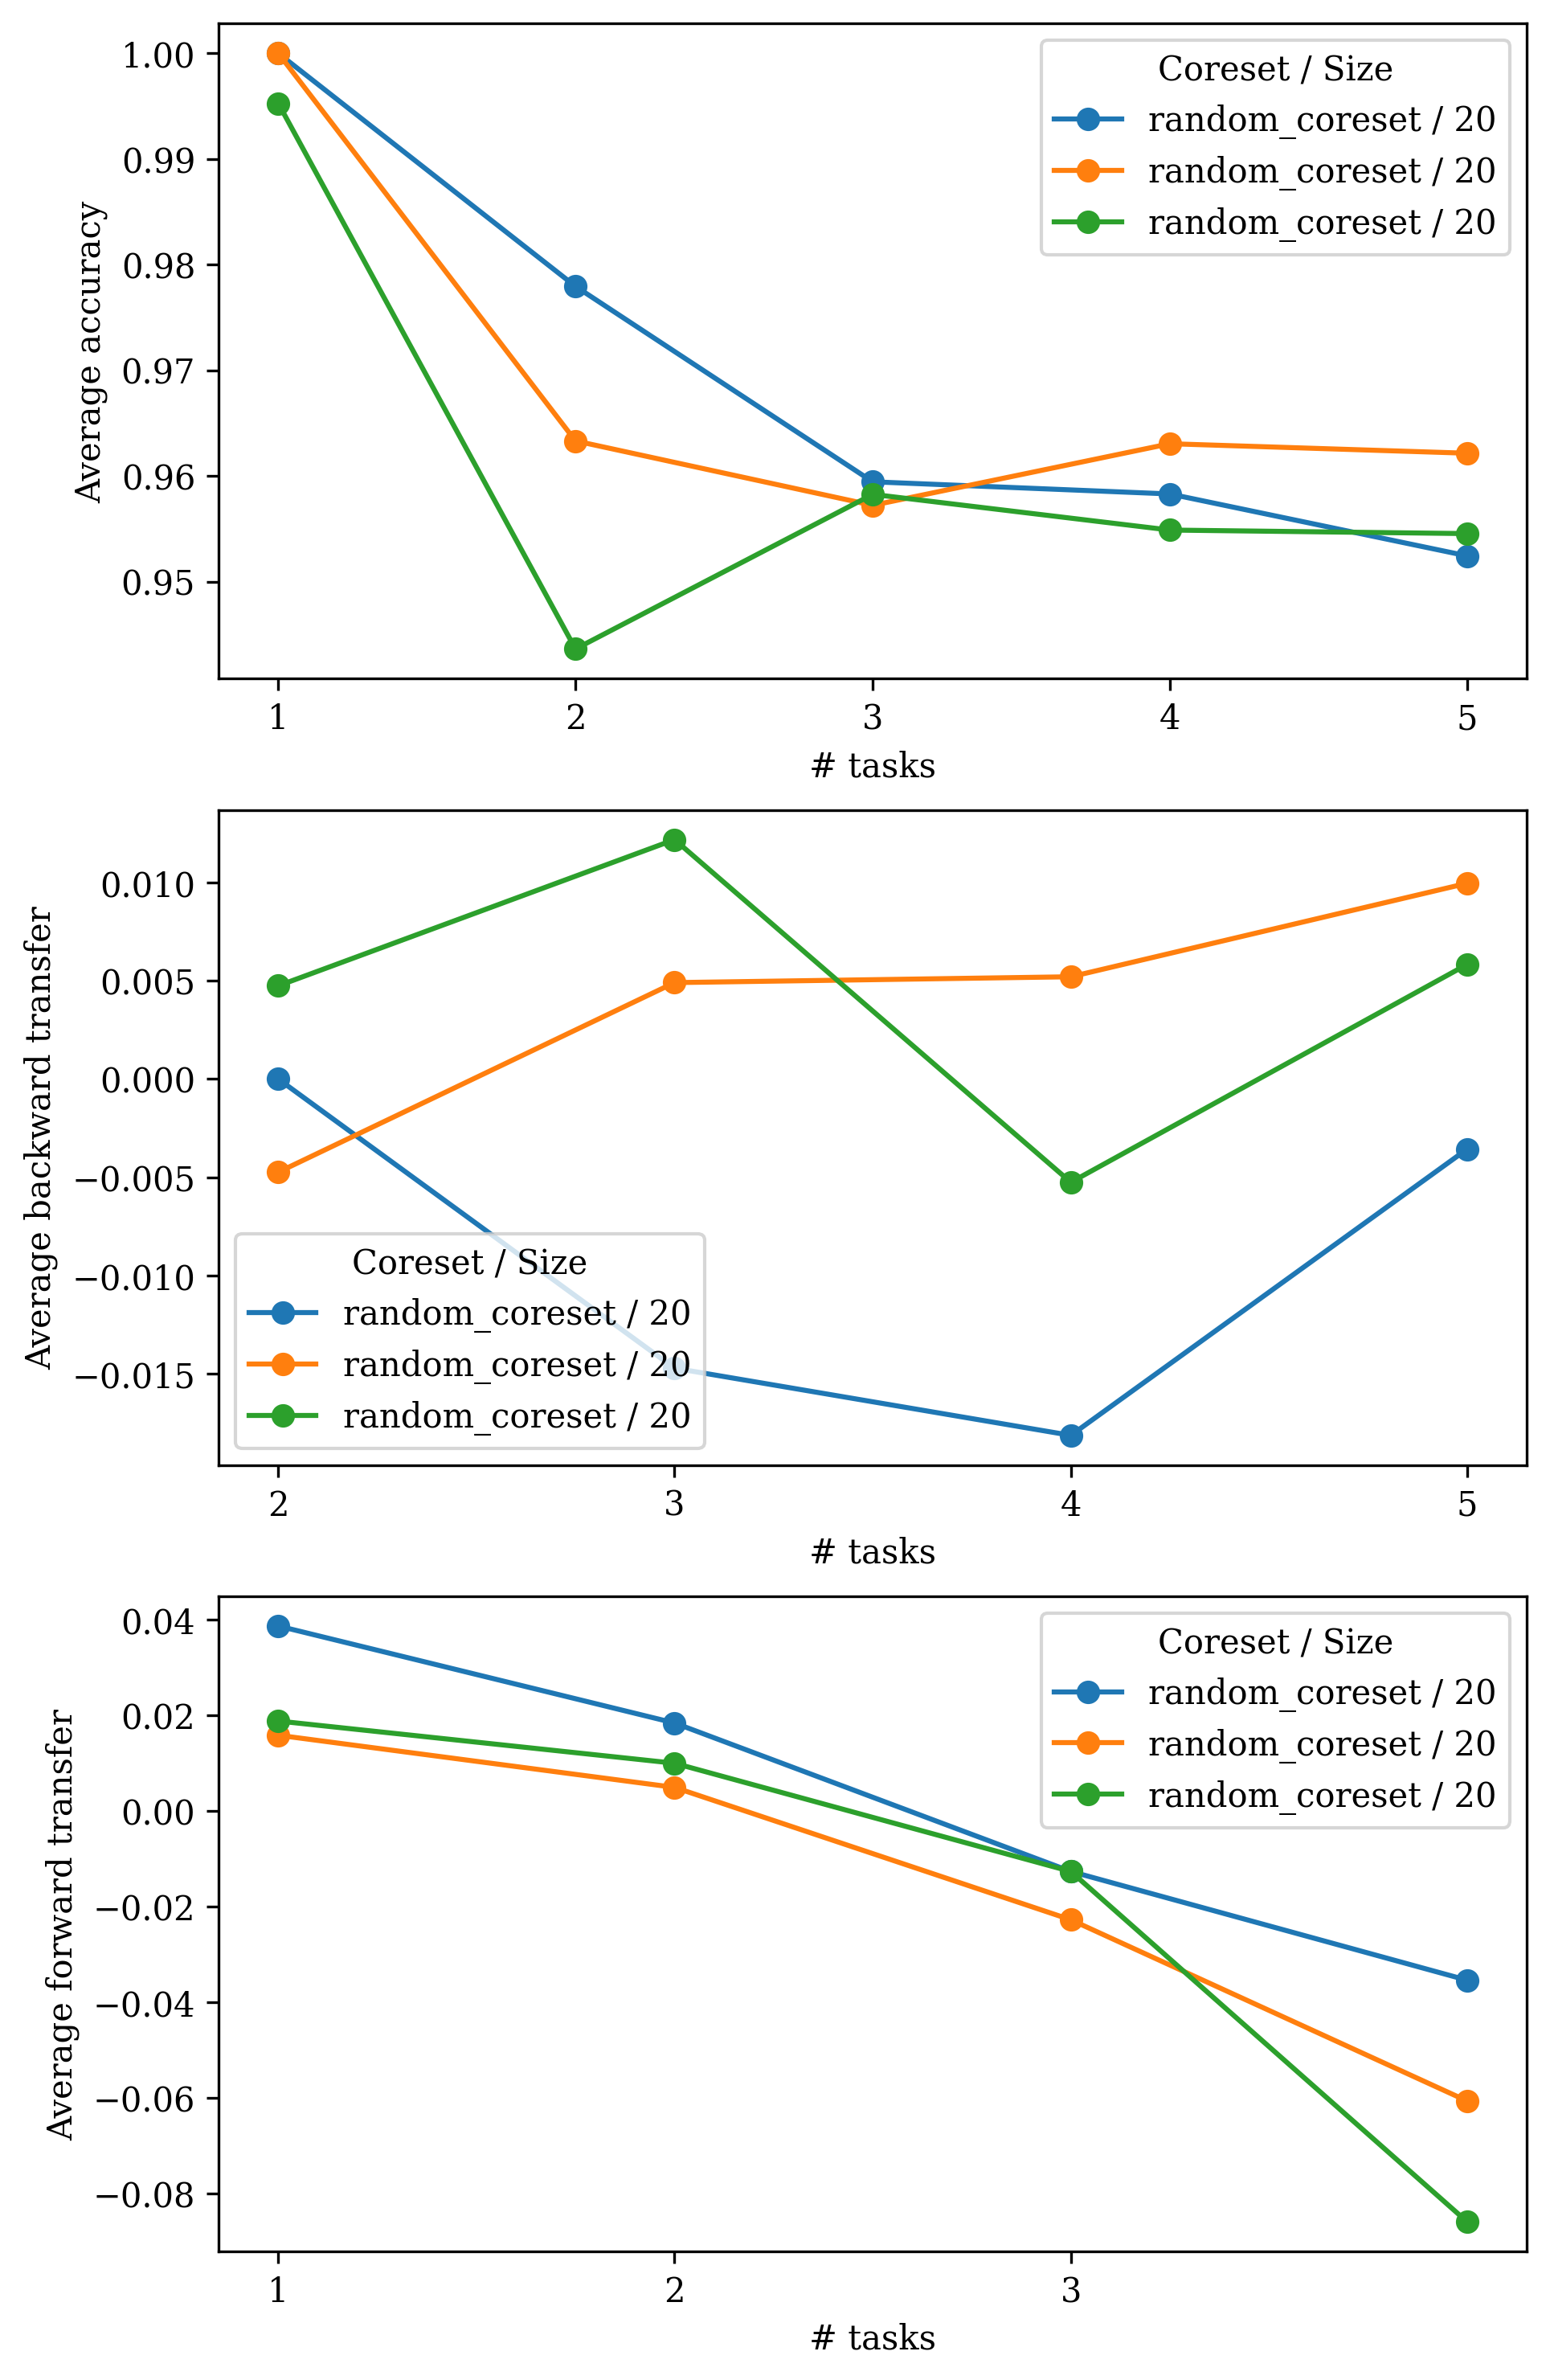

In [ ]:
num_epochs = 30
batch_size = 256
coresets = [(random_coreset, 20), (random_coreset, 20), (random_coreset, 20)]
sample_ratio = 0.1
splitmnist_constant_KL_vary_memory(num_epochs=num_epochs, batch_size=batch_size, coresets=coresets, beta=1, sample_ratio=sample_ratio)

Beta: 1 with mean KL Divergence Constant KL Divergence
Sampling 1266 samples out of 12665 for training on task [0, 1]
Sampling 211 samples out of 2115 for testing on task [0, 1]
Sampling 1208 samples out of 12089 for training on task [2, 3]
Sampling 204 samples out of 2042 for testing on task [2, 3]
Sampling 1126 samples out of 11263 for training on task [4, 5]
Sampling 187 samples out of 1874 for testing on task [4, 5]
Sampling 1218 samples out of 12183 for training on task [6, 7]
Sampling 198 samples out of 1986 for testing on task [6, 7]
Sampling 1180 samples out of 11800 for training on task [8, 9]
Sampling 198 samples out of 1983 for testing on task [8, 9]
Model Arch:
 SplitModel(
  (fc1): BBBLinear()
  (fc2): BBBLinear()
  (classifiers): ModuleList(
    (0-4): 5 x BBBLinear()
  )
)
Accuracies of the model without training: [0.60189573 0.5245098  0.43850267 0.61616162 0.45454545]

Experimenting method: random_coreset with coreset size 200
Starting Task 1


100%|██████████| 30/30 [00:10<00:00,  2.80it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.38it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.5196078431372549
Task 3 Accuracy: 0.42780748663101603
Task 4 Accuracy: 0.601010101010101
Task 5 Accuracy: 0.41414141414141414

Starting Task 2


100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.46it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.40it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9215686274509803
Task 3 Accuracy: 0.4385026737967914
Task 4 Accuracy: 0.5606060606060606
Task 5 Accuracy: 0.3787878787878788

Starting Task 3


100%|██████████| 30/30 [00:09<00:00,  3.26it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.29it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.38it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.06it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9313725490196079
Task 3 Accuracy: 0.9679144385026738
Task 4 Accuracy: 0.6111111111111112
Task 5 Accuracy: 0.4393939393939394

Starting Task 4


100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.14it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.28it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.21it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.30it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9264705882352942
Task 3 Accuracy: 0.9732620320855615
Task 4 Accuracy: 0.9949494949494949
Task 5 Accuracy: 0.43434343434343436

Starting Task 5


100%|██████████| 30/30 [00:09<00:00,  3.21it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.23it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.27it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 13.88it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.32it/s]


Replaying Task 5


100%|██████████| 30/30 [00:02<00:00, 14.37it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9411764705882353
Task 3 Accuracy: 0.9732620320855615
Task 4 Accuracy: 0.9949494949494949
Task 5 Accuracy: 0.9040404040404041

[[1.         0.51960784 0.42780749 0.6010101  0.41414141]
 [1.         0.92156863 0.43850267 0.56060606 0.37878788]
 [1.         0.93137255 0.96791444 0.61111111 0.43939394]
 [1.         0.92647059 0.97326203 0.99494949 0.43434343]
 [1.         0.94117647 0.97326203 0.99494949 0.9040404 ]]
Average accuracy on already trained tasks after each task: [1.         0.96078431 0.966429   0.97367053 0.96268568]
Average backward transfer after each task: [0.         0.00490196 0.00341652 0.00623886]
Average forward transfer after each task: [-0.01778818 -0.04377104 -0.01010101 -0.02020202]

Experimenting method: random_coreset with coreset size 200
Starting Task 1


100%|██████████| 30/30 [00:08<00:00,  3.44it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.37it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.5196078431372549
Task 3 Accuracy: 0.42780748663101603
Task 4 Accuracy: 0.5808080808080808
Task 5 Accuracy: 0.398989898989899

Starting Task 2


100%|██████████| 30/30 [00:08<00:00,  3.58it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.16it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.35it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9019607843137255
Task 3 Accuracy: 0.39572192513368987
Task 4 Accuracy: 0.6111111111111112
Task 5 Accuracy: 0.41919191919191917

Starting Task 3


100%|██████████| 30/30 [00:06<00:00,  4.29it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 13.99it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.42it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.10it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9313725490196079
Task 3 Accuracy: 0.9625668449197861
Task 4 Accuracy: 0.6515151515151515
Task 5 Accuracy: 0.4444444444444444

Starting Task 4


100%|██████████| 30/30 [00:08<00:00,  3.56it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.18it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.27it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.09it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.35it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9215686274509803
Task 3 Accuracy: 0.9732620320855615
Task 4 Accuracy: 0.9949494949494949
Task 5 Accuracy: 0.40404040404040403

Starting Task 5


100%|██████████| 30/30 [00:08<00:00,  3.55it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.44it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.31it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.32it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.32it/s]


Replaying Task 5


100%|██████████| 30/30 [00:02<00:00, 13.90it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9117647058823529
Task 3 Accuracy: 0.9732620320855615
Task 4 Accuracy: 0.9949494949494949
Task 5 Accuracy: 0.9191919191919192

[[1.         0.51960784 0.42780749 0.58080808 0.3989899 ]
 [1.         0.90196078 0.39572193 0.61111111 0.41919192]
 [1.         0.93137255 0.96256684 0.65151515 0.44444444]
 [1.         0.92156863 0.97326203 0.99494949 0.4040404 ]
 [1.         0.91176471 0.97326203 0.99494949 0.91919192]]
Average accuracy on already trained tasks after each task: [1.         0.95098039 0.96464646 0.97244504 0.95983363]
Average backward transfer after each task: [0.         0.01470588 0.01010101 0.00512478]
Average forward transfer after each task: [-0.02662656 -0.02772826  0.01262626 -0.05050505]

Experimenting method: random_coreset with coreset size 200
Starting Task 1


100%|██████████| 30/30 [00:06<00:00,  4.51it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.18it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.5196078431372549
Task 3 Accuracy: 0.42245989304812837
Task 4 Accuracy: 0.5454545454545454
Task 5 Accuracy: 0.3686868686868687

Starting Task 2


100%|██████████| 30/30 [00:06<00:00,  4.72it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.40it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.11it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.8970588235294118
Task 3 Accuracy: 0.4385026737967914
Task 4 Accuracy: 0.6060606060606061
Task 5 Accuracy: 0.398989898989899

Starting Task 3


100%|██████████| 30/30 [00:05<00:00,  5.09it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.27it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.26it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.34it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9117647058823529
Task 3 Accuracy: 0.9625668449197861
Task 4 Accuracy: 0.5909090909090909
Task 5 Accuracy: 0.3939393939393939

Starting Task 4


100%|██████████| 30/30 [00:06<00:00,  4.68it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.11it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.32it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.12it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.16it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9362745098039216
Task 3 Accuracy: 0.9625668449197861
Task 4 Accuracy: 0.98989898989899
Task 5 Accuracy: 0.43434343434343436

Starting Task 5


100%|██████████| 30/30 [00:06<00:00,  4.85it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.21it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.16it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.25it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.28it/s]


Replaying Task 5


100%|██████████| 30/30 [00:02<00:00, 14.30it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9117647058823529
Task 3 Accuracy: 0.9732620320855615
Task 4 Accuracy: 0.98989898989899
Task 5 Accuracy: 0.8939393939393939

[[1.         0.51960784 0.42245989 0.54545455 0.36868687]
 [1.         0.89705882 0.43850267 0.60606061 0.3989899 ]
 [1.         0.91176471 0.96256684 0.59090909 0.39393939]
 [1.         0.93627451 0.96256684 0.98989899 0.43434343]
 [1.         0.91176471 0.97326203 0.98989899 0.89393939]]
Average accuracy on already trained tasks after each task: [1.         0.94852941 0.95811052 0.97218509 0.95377302]
Average backward transfer after each task: [0.         0.00735294 0.0130719  0.00635027]
Average forward transfer after each task: [-0.0443776  -0.02188552 -0.04292929 -0.02020202]


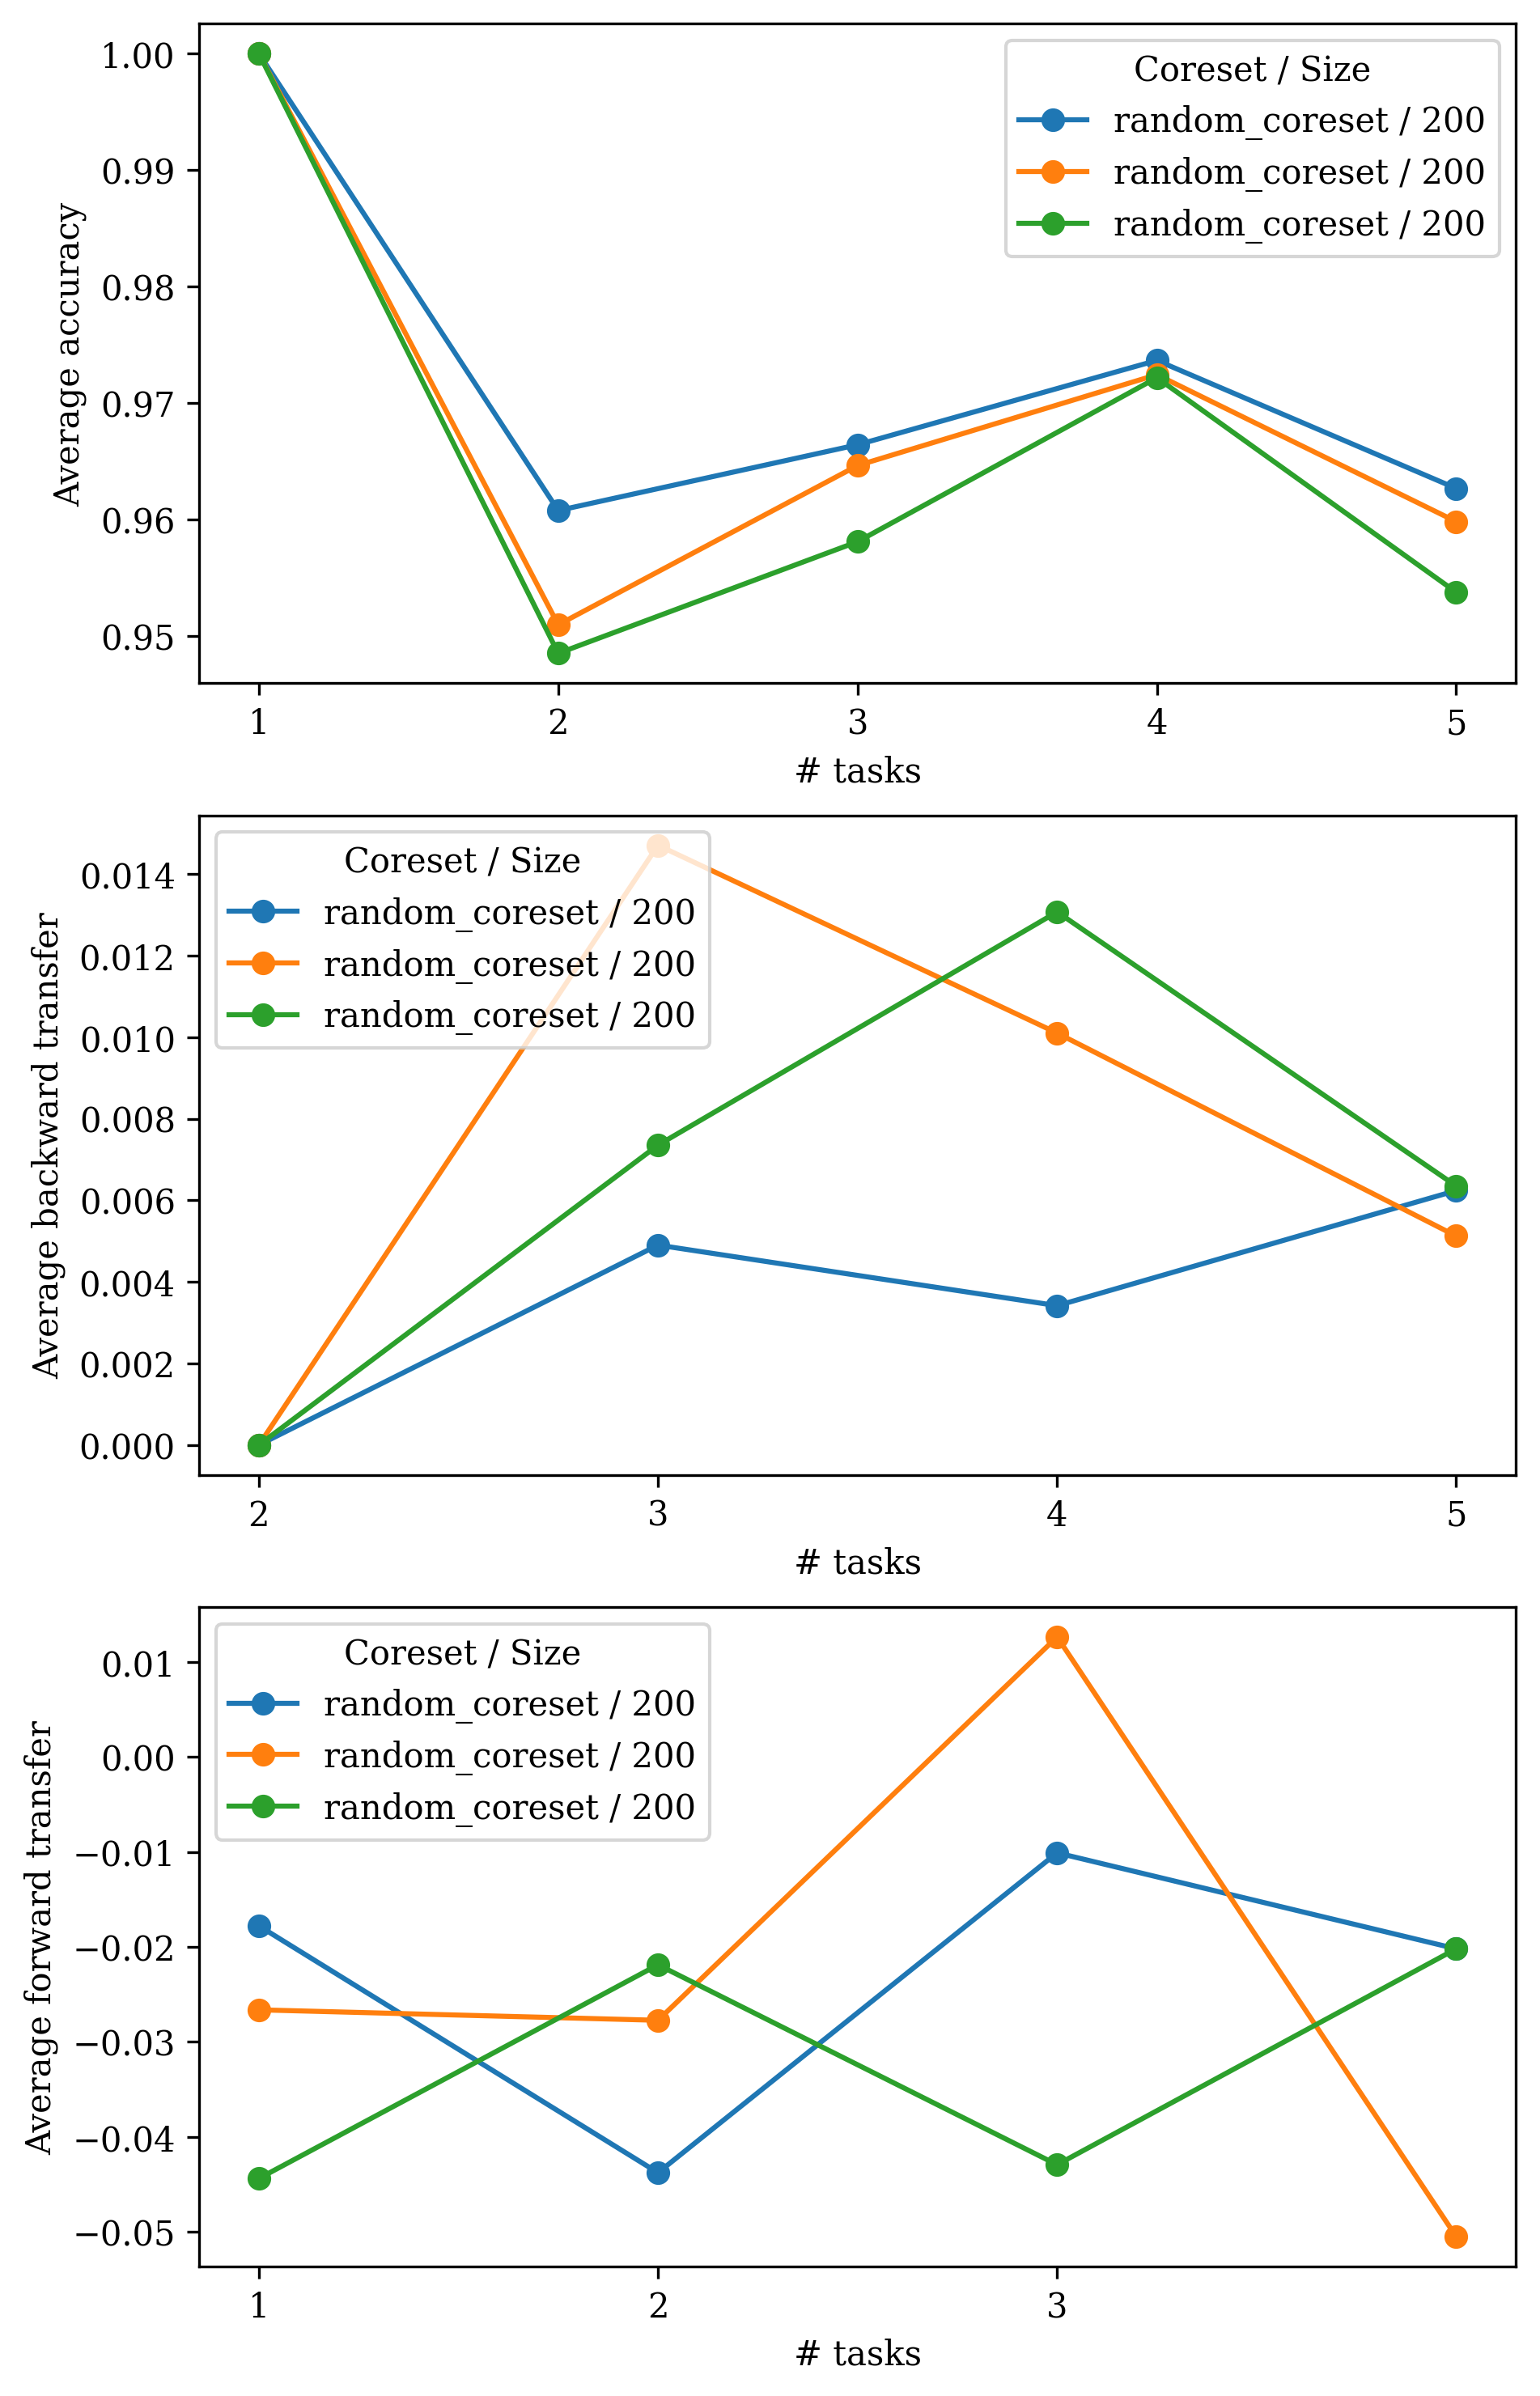

In [ ]:
num_epochs = 30
batch_size = 256
coresets = [(random_coreset, 200), (random_coreset, 200), (random_coreset, 200)]
sample_ratio = 0.1
splitmnist_constant_KL_vary_memory(num_epochs=num_epochs, batch_size=batch_size, coresets=coresets, beta=1, sample_ratio=sample_ratio)

## Second experiment
Look at what happens, when (by chance) we only sample one class
Already has an effect, even with relatively small coreset

Beta: 1 with mean KL Divergence Constant KL Divergence
Sampling 1266 samples out of 12665 for training on task [0, 1]
Sampling 211 samples out of 2115 for testing on task [0, 1]
Sampling 1208 samples out of 12089 for training on task [2, 3]
Sampling 204 samples out of 2042 for testing on task [2, 3]
Sampling 1126 samples out of 11263 for training on task [4, 5]
Sampling 187 samples out of 1874 for testing on task [4, 5]
Sampling 1218 samples out of 12183 for training on task [6, 7]
Sampling 198 samples out of 1986 for testing on task [6, 7]
Sampling 1180 samples out of 11800 for training on task [8, 9]
Sampling 198 samples out of 1983 for testing on task [8, 9]
Model Arch:
 SplitModel(
  (fc1): BBBLinear()
  (fc2): BBBLinear()
  (classifiers): ModuleList(
    (0-4): 5 x BBBLinear()
  )
)
Accuracies of the model without training: [0.19905213 0.39215686 0.49197861 0.42424242 0.56060606]

Experimenting method: one_class with coreset size 20
Starting Task 1


100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.52it/s]


Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.4019607843137255
Task 3 Accuracy: 0.47058823529411764
Task 4 Accuracy: 0.41919191919191917
Task 5 Accuracy: 0.5959595959595959

Starting Task 2


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.09it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.45it/s]


Task 1 Accuracy: 0.985781990521327
Task 2 Accuracy: 0.6715686274509803
Task 3 Accuracy: 0.3850267379679144
Task 4 Accuracy: 0.398989898989899
Task 5 Accuracy: 0.5959595959595959

Starting Task 3


100%|██████████| 30/30 [00:11<00:00,  2.71it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.28it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.49it/s]


Replaying Task 3


100%|██████████| 30/30 [00:01<00:00, 26.49it/s]


Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.6274509803921569
Task 3 Accuracy: 0.7967914438502673
Task 4 Accuracy: 0.4090909090909091
Task 5 Accuracy: 0.5555555555555556

Starting Task 4


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.63it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.68it/s]


Replaying Task 3


100%|██████████| 30/30 [00:01<00:00, 26.63it/s]


Replaying Task 4


100%|██████████| 30/30 [00:01<00:00, 26.47it/s]


Task 1 Accuracy: 0.990521327014218
Task 2 Accuracy: 0.5735294117647058
Task 3 Accuracy: 0.7433155080213903
Task 4 Accuracy: 0.9747474747474747
Task 5 Accuracy: 0.5050505050505051

Starting Task 5


100%|██████████| 30/30 [00:11<00:00,  2.65it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.14it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 27.16it/s]


Replaying Task 3


100%|██████████| 30/30 [00:01<00:00, 26.85it/s]


Replaying Task 4


100%|██████████| 30/30 [00:01<00:00, 27.29it/s]


Replaying Task 5


100%|██████████| 30/30 [00:01<00:00, 27.08it/s]


Task 1 Accuracy: 0.990521327014218
Task 2 Accuracy: 0.5686274509803921
Task 3 Accuracy: 0.8021390374331551
Task 4 Accuracy: 0.9747474747474747
Task 5 Accuracy: 0.6060606060606061

[[0.99526066 0.40196078 0.47058824 0.41919192 0.5959596 ]
 [0.98578199 0.67156863 0.38502674 0.3989899  0.5959596 ]
 [0.99526066 0.62745098 0.79679144 0.40909091 0.55555556]
 [0.99052133 0.57352941 0.74331551 0.97474747 0.50505051]
 [0.99052133 0.56862745 0.80213904 0.97474747 0.60606061]]
Average accuracy on already trained tasks after each task: [0.99526066 0.82867531 0.80650103 0.82052843 0.78841918]
Average backward transfer after each task: [-0.00947867 -0.02205882 -0.05208483 -0.02558323]
Average forward transfer after each task: [ 0.00467914 -0.03228362 -0.01010101 -0.05555556]

Experimenting method: None with coreset size 0
Starting Task 1


100%|██████████| 30/30 [00:12<00:00,  2.50it/s]


Done Training Task 1

Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.4117647058823529
Task 3 Accuracy: 0.47058823529411764
Task 4 Accuracy: 0.4444444444444444
Task 5 Accuracy: 0.5808080808080808

Starting Task 2


100%|██████████| 30/30 [00:11<00:00,  2.61it/s]


Done Training Task 2

Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9411764705882353
Task 3 Accuracy: 0.37967914438502676
Task 4 Accuracy: 0.42424242424242425
Task 5 Accuracy: 0.6262626262626263

Starting Task 3


100%|██████████| 30/30 [00:10<00:00,  2.73it/s]


Done Training Task 3

Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9558823529411765
Task 3 Accuracy: 0.9786096256684492
Task 4 Accuracy: 0.4292929292929293
Task 5 Accuracy: 0.5050505050505051

Starting Task 4


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]


Done Training Task 4

Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9656862745098039
Task 3 Accuracy: 0.9518716577540107
Task 4 Accuracy: 0.98989898989899
Task 5 Accuracy: 0.5050505050505051

Starting Task 5


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Done Training Task 5

Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9705882352941176
Task 3 Accuracy: 0.9625668449197861
Task 4 Accuracy: 0.9797979797979798
Task 5 Accuracy: 0.9292929292929293

[[1.         0.41176471 0.47058824 0.44444444 0.58080808]
 [1.         0.94117647 0.37967914 0.42424242 0.62626263]
 [1.         0.95588235 0.97860963 0.42929293 0.50505051]
 [1.         0.96568627 0.95187166 0.98989899 0.50505051]
 [1.         0.97058824 0.96256684 0.97979798 0.92929293]]
Average accuracy on already trained tasks after each task: [1.         0.97058824 0.97816399 0.97686423 0.9684492 ]
Average backward transfer after each task: [ 0.          0.00735294 -0.00074272  0.00081699]
Average forward transfer after each task: [ 0.00965538 -0.01554763 -0.02525253 -0.05555556]

Experimenting method: random_coreset with coreset size 20
Starting Task 1


100%|██████████| 30/30 [00:11<00:00,  2.54it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.69it/s]


Task 1 Accuracy: 0.990521327014218
Task 2 Accuracy: 0.3627450980392157
Task 3 Accuracy: 0.5294117647058824
Task 4 Accuracy: 0.42424242424242425
Task 5 Accuracy: 0.6262626262626263

Starting Task 2


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.48it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.15it/s]


Task 1 Accuracy: 0.990521327014218
Task 2 Accuracy: 0.9656862745098039
Task 3 Accuracy: 0.42245989304812837
Task 4 Accuracy: 0.4393939393939394
Task 5 Accuracy: 0.6060606060606061

Starting Task 3


100%|██████████| 30/30 [00:10<00:00,  2.75it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 27.14it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 27.40it/s]


Replaying Task 3


100%|██████████| 30/30 [00:01<00:00, 26.58it/s]


Task 1 Accuracy: 0.990521327014218
Task 2 Accuracy: 0.9803921568627451
Task 3 Accuracy: 0.9625668449197861
Task 4 Accuracy: 0.3939393939393939
Task 5 Accuracy: 0.5505050505050505

Starting Task 4


100%|██████████| 30/30 [00:11<00:00,  2.63it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.49it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.26it/s]


Replaying Task 3


100%|██████████| 30/30 [00:01<00:00, 27.07it/s]


Replaying Task 4


100%|██████████| 30/30 [00:01<00:00, 27.08it/s]


Task 1 Accuracy: 0.990521327014218
Task 2 Accuracy: 0.946078431372549
Task 3 Accuracy: 0.9679144385026738
Task 4 Accuracy: 0.98989898989899
Task 5 Accuracy: 0.4696969696969697

Starting Task 5


100%|██████████| 30/30 [00:11<00:00,  2.63it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 30/30 [00:01<00:00, 26.78it/s]


Replaying Task 2


100%|██████████| 30/30 [00:01<00:00, 26.24it/s]


Replaying Task 3


100%|██████████| 30/30 [00:01<00:00, 26.14it/s]


Replaying Task 4


100%|██████████| 30/30 [00:01<00:00, 26.81it/s]


Replaying Task 5


100%|██████████| 30/30 [00:01<00:00, 26.26it/s]


Task 1 Accuracy: 0.990521327014218
Task 2 Accuracy: 0.9509803921568627
Task 3 Accuracy: 0.9786096256684492
Task 4 Accuracy: 0.9848484848484849
Task 5 Accuracy: 0.8939393939393939

[[0.99052133 0.3627451  0.52941176 0.42424242 0.62626263]
 [0.99052133 0.96568627 0.42245989 0.43939394 0.60606061]
 [0.99052133 0.98039216 0.96256684 0.39393939 0.55050505]
 [0.99052133 0.94607843 0.96791444 0.98989899 0.46969697]
 [0.99052133 0.95098039 0.97860963 0.98484848 0.89393939]]
Average accuracy on already trained tasks after each task: [0.99052133 0.9781038  0.97782678 0.9736033  0.95977984]
Average backward transfer after each task: [ 0.          0.00735294 -0.00475342 -0.0009284 ]
Average forward transfer after each task: [ 0.01841949 -0.00297089 -0.02020202 -0.09090909]


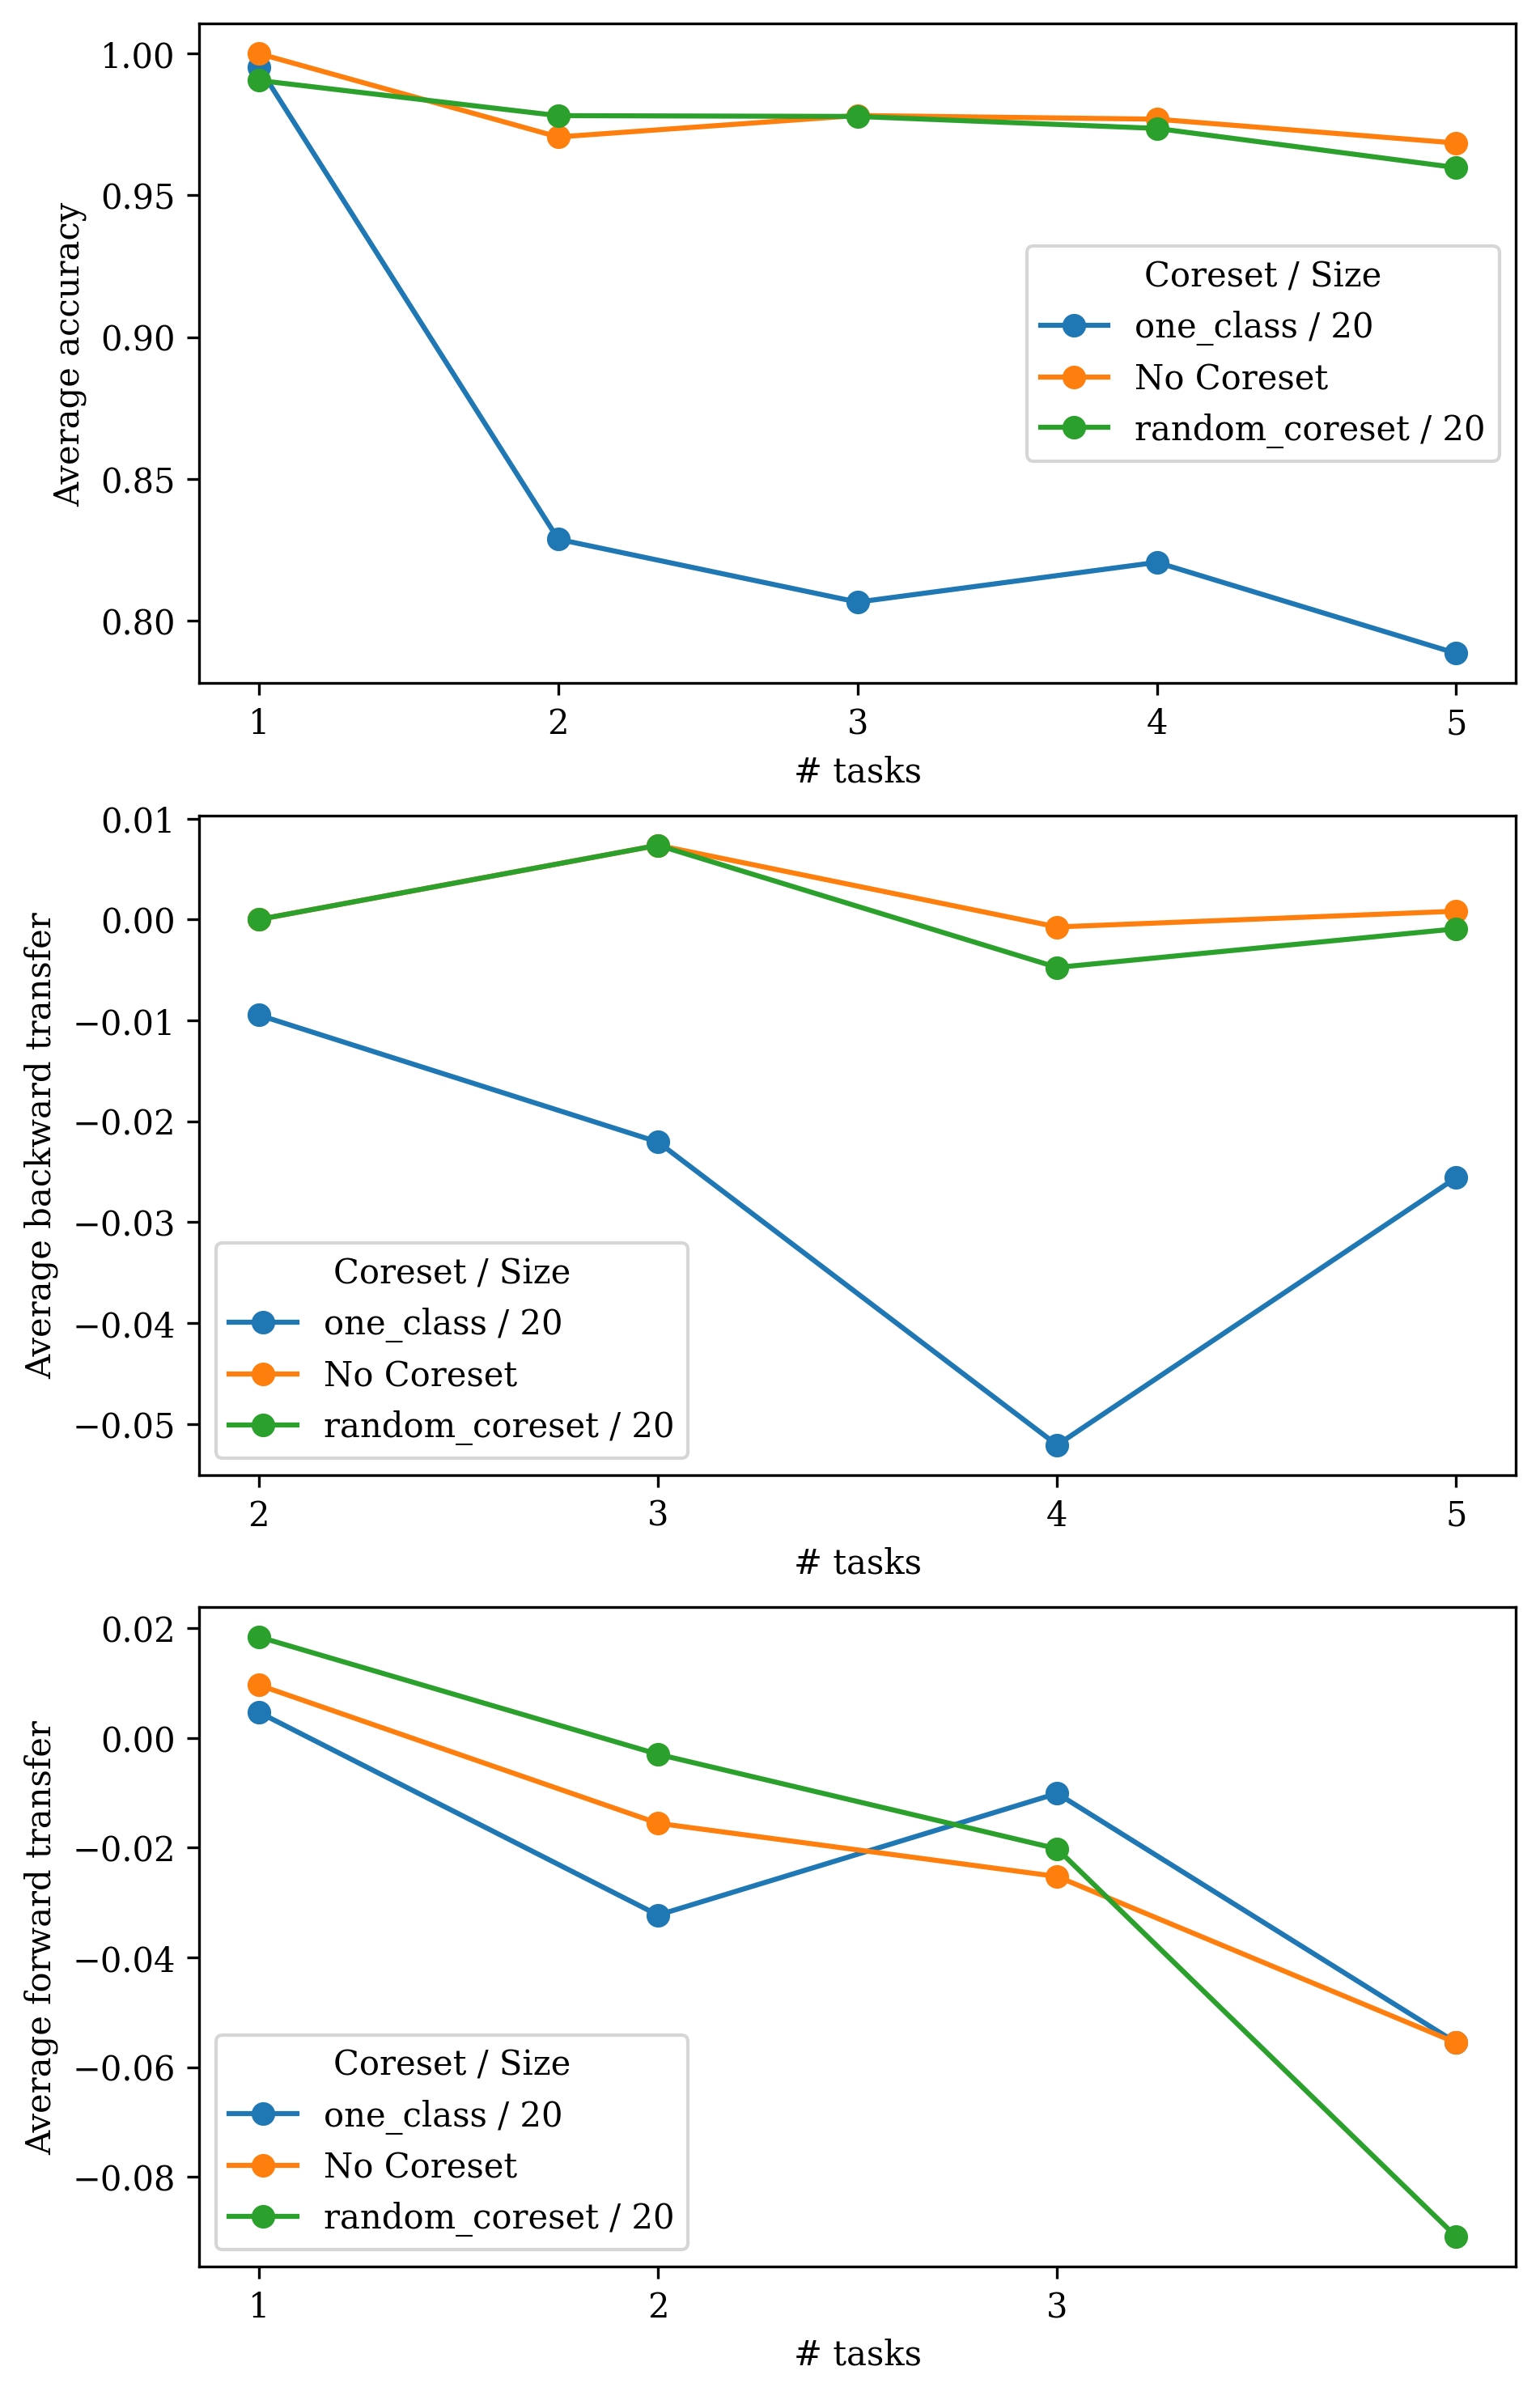

In [ ]:
num_epochs = 30
batch_size = 256
coresets = [(one_class, 20), (None, 0), (random_coreset, 20)]
sample_ratio = 0.1
splitmnist_constant_KL_vary_memory(num_epochs=num_epochs, batch_size=batch_size, coresets=coresets, beta=1, sample_ratio=sample_ratio)

Beta: 1 with mean KL Divergence Constant KL Divergence
Sampling 1266 samples out of 12665 for training on task [0, 1]
Sampling 211 samples out of 2115 for testing on task [0, 1]
Sampling 1208 samples out of 12089 for training on task [2, 3]
Sampling 204 samples out of 2042 for testing on task [2, 3]
Sampling 1126 samples out of 11263 for training on task [4, 5]
Sampling 187 samples out of 1874 for testing on task [4, 5]
Sampling 1218 samples out of 12183 for training on task [6, 7]
Sampling 198 samples out of 1986 for testing on task [6, 7]
Sampling 1180 samples out of 11800 for training on task [8, 9]
Sampling 198 samples out of 1983 for testing on task [8, 9]
Model Arch:
 SplitModel(
  (fc1): BBBLinear()
  (fc2): BBBLinear()
  (classifiers): ModuleList(
    (0-4): 5 x BBBLinear()
  )
)
Accuracies of the model without training: [0.44075829 0.44607843 0.4171123  0.34848485 0.35858586]

Experimenting method: one_class with coreset size 200
Starting Task 1


100%|██████████| 30/30 [00:10<00:00,  2.76it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.16it/s]


Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.4950980392156863
Task 3 Accuracy: 0.42780748663101603
Task 4 Accuracy: 0.35858585858585856
Task 5 Accuracy: 0.3939393939393939

Starting Task 2


100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.12it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.30it/s]


Task 1 Accuracy: 0.990521327014218
Task 2 Accuracy: 0.5686274509803921
Task 3 Accuracy: 0.44919786096256686
Task 4 Accuracy: 0.4090909090909091
Task 5 Accuracy: 0.3888888888888889

Starting Task 3


100%|██████████| 30/30 [00:09<00:00,  3.31it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.28it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.21it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.18it/s]


Task 1 Accuracy: 0.976303317535545
Task 2 Accuracy: 0.5980392156862745
Task 3 Accuracy: 0.6256684491978609
Task 4 Accuracy: 0.3888888888888889
Task 5 Accuracy: 0.42424242424242425

Starting Task 4


100%|██████████| 30/30 [00:09<00:00,  3.16it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.31it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.21it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.42it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.23it/s]


Task 1 Accuracy: 0.95260663507109
Task 2 Accuracy: 0.5294117647058824
Task 3 Accuracy: 0.5561497326203209
Task 4 Accuracy: 0.9141414141414141
Task 5 Accuracy: 0.5202020202020202

Starting Task 5


100%|██████████| 30/30 [00:09<00:00,  3.17it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.32it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.08it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.18it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.23it/s]


Replaying Task 5


100%|██████████| 30/30 [00:02<00:00, 14.28it/s]


Task 1 Accuracy: 0.9383886255924171
Task 2 Accuracy: 0.5245098039215687
Task 3 Accuracy: 0.6203208556149733
Task 4 Accuracy: 0.9040404040404041
Task 5 Accuracy: 0.5606060606060606

[[0.99526066 0.49509804 0.42780749 0.35858586 0.39393939]
 [0.99052133 0.56862745 0.44919786 0.40909091 0.38888889]
 [0.97630332 0.59803922 0.62566845 0.38888889 0.42424242]
 [0.95260664 0.52941176 0.55614973 0.91414141 0.52020202]
 [0.93838863 0.5245098  0.62032086 0.9040404  0.56060606]]
Average accuracy on already trained tasks after each task: [0.99526066 0.77957439 0.73333699 0.73807739 0.70957315]
Average backward transfer after each task: [-0.00473934  0.00522721 -0.05046281 -0.02910957]
Average forward transfer after each task: [0.02629234 0.04099822 0.0530303  0.16161616]

Experimenting method: None with coreset size 0
Starting Task 1


100%|██████████| 30/30 [00:10<00:00,  2.78it/s]


Done Training Task 1

Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.5343137254901961
Task 3 Accuracy: 0.41711229946524064
Task 4 Accuracy: 0.3888888888888889
Task 5 Accuracy: 0.35858585858585856

Starting Task 2


100%|██████████| 30/30 [00:09<00:00,  3.13it/s]


Done Training Task 2

Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.8921568627450981
Task 3 Accuracy: 0.40641711229946526
Task 4 Accuracy: 0.30303030303030304
Task 5 Accuracy: 0.3888888888888889

Starting Task 3


100%|██████████| 30/30 [00:09<00:00,  3.28it/s]


Done Training Task 3

Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.8774509803921569
Task 3 Accuracy: 0.9732620320855615
Task 4 Accuracy: 0.3383838383838384
Task 5 Accuracy: 0.36363636363636365

Starting Task 4


100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Done Training Task 4

Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9166666666666666
Task 3 Accuracy: 0.9679144385026738
Task 4 Accuracy: 0.9696969696969697
Task 5 Accuracy: 0.398989898989899

Starting Task 5


100%|██████████| 30/30 [00:09<00:00,  3.19it/s]


Done Training Task 5

Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9215686274509803
Task 3 Accuracy: 0.9786096256684492
Task 4 Accuracy: 0.9747474747474747
Task 5 Accuracy: 0.9090909090909091

[[1.         0.53431373 0.4171123  0.38888889 0.35858586]
 [0.99526066 0.89215686 0.40641711 0.3030303  0.38888889]
 [0.99526066 0.87745098 0.97326203 0.33838384 0.36363636]
 [1.         0.91666667 0.96791444 0.96969697 0.3989899 ]
 [1.         0.92156863 0.97860963 0.97474747 0.90909091]]
Average accuracy on already trained tasks after each task: [1.         0.94370876 0.94865789 0.96356952 0.95680333]
Average backward transfer after each task: [-0.00473934 -0.00972261  0.0063874   0.00995247]
Average forward transfer after each task: [ 0.03215983 -0.00861557 -0.00252525  0.04040404]

Experimenting method: random_coreset with coreset size 200
Starting Task 1


100%|██████████| 30/30 [00:08<00:00,  3.37it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.16it/s]


Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.4852941176470588
Task 3 Accuracy: 0.44385026737967914
Task 4 Accuracy: 0.35353535353535354
Task 5 Accuracy: 0.36363636363636365

Starting Task 2


100%|██████████| 30/30 [00:08<00:00,  3.57it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.23it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 13.94it/s]


Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.946078431372549
Task 3 Accuracy: 0.43315508021390375
Task 4 Accuracy: 0.3181818181818182
Task 5 Accuracy: 0.40404040404040403

Starting Task 3


100%|██████████| 30/30 [00:07<00:00,  4.28it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.16it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 13.95it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.23it/s]


Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.9215686274509803
Task 3 Accuracy: 0.9572192513368984
Task 4 Accuracy: 0.3484848484848485
Task 5 Accuracy: 0.3686868686868687

Starting Task 4


100%|██████████| 30/30 [00:08<00:00,  3.53it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.18it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.26it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.18it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.33it/s]


Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.9166666666666666
Task 3 Accuracy: 0.9572192513368984
Task 4 Accuracy: 0.9696969696969697
Task 5 Accuracy: 0.398989898989899

Starting Task 5


100%|██████████| 30/30 [00:08<00:00,  3.63it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.29it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.16it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.13it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.35it/s]


Replaying Task 5


100%|██████████| 30/30 [00:02<00:00, 14.26it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9313725490196079
Task 3 Accuracy: 0.9786096256684492
Task 4 Accuracy: 0.9696969696969697
Task 5 Accuracy: 0.9141414141414141

[[0.99526066 0.48529412 0.44385027 0.35353535 0.36363636]
 [0.99526066 0.94607843 0.43315508 0.31818182 0.4040404 ]
 [0.99526066 0.92156863 0.95721925 0.34848485 0.36868687]
 [0.99526066 0.91666667 0.95721925 0.96969697 0.3989899 ]
 [1.         0.93137255 0.97860963 0.96969697 0.91414141]]
Average accuracy on already trained tasks after each task: [0.99526066 0.97066955 0.95801618 0.95971089 0.95876411]
Average backward transfer after each task: [ 0.         -0.0122549  -0.00980392  0.00285596]
Average forward transfer after each task: [0.01901367 0.0103981  0.00505051 0.04040404]


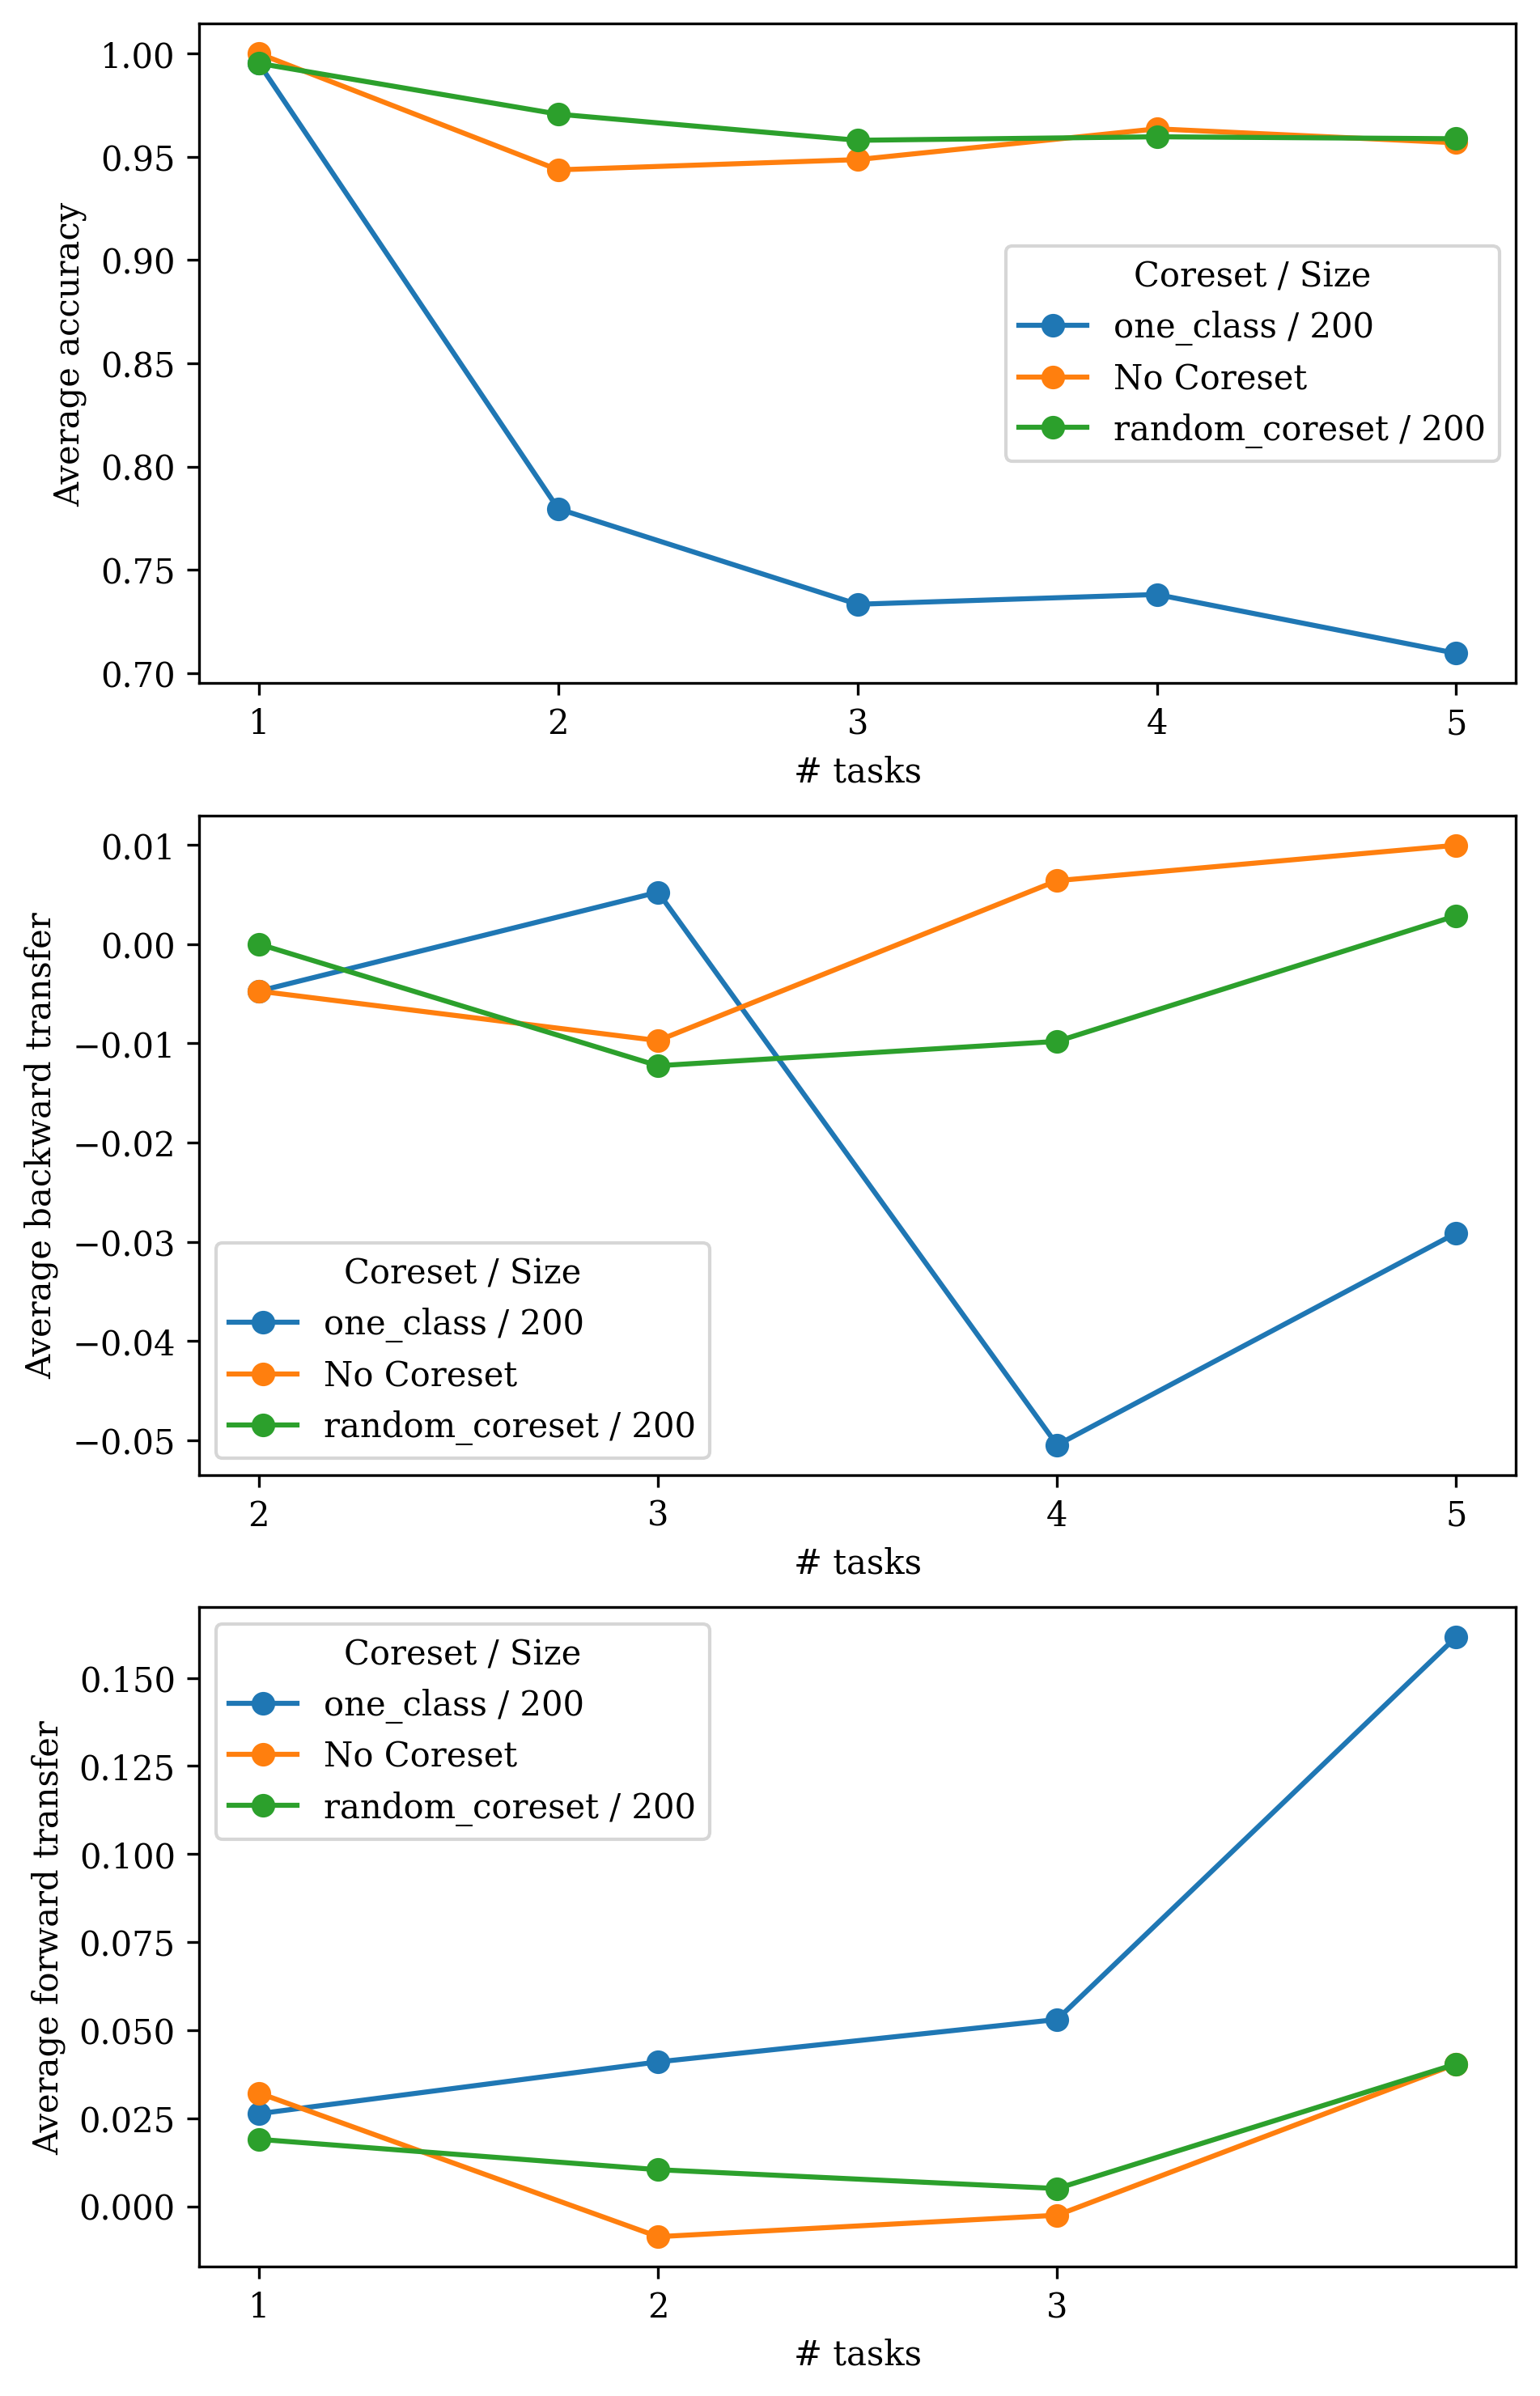

In [ ]:
num_epochs = 30
batch_size = 256
coresets = [(one_class, 200), (None, 0), (random_coreset, 200)]
sample_ratio = 0.1
splitmnist_constant_KL_vary_memory(num_epochs=num_epochs, batch_size=batch_size, coresets=coresets, beta=1, sample_ratio=sample_ratio)

## Third experiment
Add chosing by certainty measurements

Beta: 1 with mean KL Divergence Constant KL Divergence
Sampling 1266 samples out of 12665 for training on task [0, 1]
Sampling 211 samples out of 2115 for testing on task [0, 1]
Sampling 1208 samples out of 12089 for training on task [2, 3]
Sampling 204 samples out of 2042 for testing on task [2, 3]
Sampling 1126 samples out of 11263 for training on task [4, 5]
Sampling 187 samples out of 1874 for testing on task [4, 5]
Sampling 1218 samples out of 12183 for training on task [6, 7]
Sampling 198 samples out of 1986 for testing on task [6, 7]
Sampling 1180 samples out of 11800 for training on task [8, 9]
Sampling 198 samples out of 1983 for testing on task [8, 9]
Model Arch:
 SplitModel(
  (fc1): BBBLinear()
  (fc2): BBBLinear()
  (classifiers): ModuleList(
    (0-4): 5 x BBBLinear()
  )
)
Accuracies of the model without training: [0.6492891  0.47058824 0.64705882 0.46464646 0.43939394]

Experimenting method: rainbow_select with coreset size 200
Starting Task 1
Dummy model achieves accur

100%|██████████| 30/30 [00:11<00:00,  2.72it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.24it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.44607843137254904
Task 3 Accuracy: 0.6256684491978609
Task 4 Accuracy: 0.5202020202020202
Task 5 Accuracy: 0.43434343434343436

Starting Task 2
Dummy model achieves accuracy 0.8657269021739131
task_indices: tensor([   5,    7,   10,  ..., 6063, 6069, 6071])

class: 0
Sampling 97 / 200 samples for class 0

class: 1
Sampling 103 / 200 samples for class 1
Selected a coreset with a average certainty in the dummy model of 0.8297773599624634
          compared to 0.7655568718910217 in the whole dataset and 0.7528148293495178 in the non-core dataset


100%|██████████| 30/30 [00:09<00:00,  3.15it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.13it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.00it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9362745098039216
Task 3 Accuracy: 0.6951871657754011
Task 4 Accuracy: 0.5252525252525253
Task 5 Accuracy: 0.43434343434343436

Starting Task 3
Dummy model achieves accuracy 0.8831188725490197
task_indices: tensor([   0,    2,    9,  ..., 5934, 5936, 5939])

class: 0
Sampling 109 / 200 samples for class 0

class: 1
Sampling 91 / 200 samples for class 1
Selected a coreset with a average certainty in the dummy model of 0.8109683990478516
          compared to 0.7410804033279419 in the whole dataset and 0.7259857654571533 in the non-core dataset


100%|██████████| 30/30 [00:09<00:00,  3.29it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.24it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.05it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.14it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9411764705882353
Task 3 Accuracy: 0.9679144385026738
Task 4 Accuracy: 0.48484848484848486
Task 5 Accuracy: 0.43434343434343436

Starting Task 4
Dummy model achieves accuracy 0.9251610824742269
task_indices: tensor([  13,   15,   18,  ..., 5802, 5804, 5810])

class: 0
Sampling 95 / 200 samples for class 0

class: 1
Sampling 105 / 200 samples for class 1
Selected a coreset with a average certainty in the dummy model of 0.8564255833625793
          compared to 0.8400237560272217 in the whole dataset and 0.8368014693260193 in the non-core dataset


100%|██████████| 30/30 [00:09<00:00,  3.14it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.21it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.10it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.05it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.17it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9215686274509803
Task 3 Accuracy: 0.9625668449197861
Task 4 Accuracy: 0.9494949494949495
Task 5 Accuracy: 0.4595959595959596

Starting Task 5
Dummy model achieves accuracy 0.8630208333333333
task_indices: tensor([   4,   17,   19,  ..., 6145, 6149, 6152])

class: 0
Sampling 95 / 200 samples for class 0

class: 1
Sampling 105 / 200 samples for class 1
Selected a coreset with a average certainty in the dummy model of 0.7928099036216736
          compared to 0.7048277258872986 in the whole dataset and 0.6868721842765808 in the non-core dataset


100%|██████████| 30/30 [00:09<00:00,  3.18it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.20it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.15it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.17it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 13.89it/s]


Replaying Task 5


100%|██████████| 30/30 [00:02<00:00, 14.18it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9509803921568627
Task 3 Accuracy: 0.9732620320855615
Task 4 Accuracy: 0.9545454545454546
Task 5 Accuracy: 0.9343434343434344

[[1.         0.44607843 0.62566845 0.52020202 0.43434343]
 [1.         0.93627451 0.69518717 0.52525253 0.43434343]
 [1.         0.94117647 0.96791444 0.48484848 0.43434343]
 [1.         0.92156863 0.96256684 0.94949495 0.45959596]
 [1.         0.95098039 0.97326203 0.95454545 0.93434343]]
Average accuracy on already trained tasks after each task: [1.         0.96813725 0.96969697 0.95840761 0.96262626]
Average backward transfer after each task: [ 0.          0.00245098 -0.00668449  0.006276  ]
Average forward transfer after each task: [0.00115122 0.0345613  0.00757576 0.02020202]

Experimenting method: select_certain with coreset size 200
Starting Task 1
Dummy model achieves accuracy 0.9663318452380952
task_indices: tensor([5204, 2557, 2530,  ...,  398,  943, 5905])

class: 0
Sampling 95 / 200 samples for class 0

class: 

100%|██████████| 30/30 [00:08<00:00,  3.38it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.26it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.47058823529411764
Task 3 Accuracy: 0.6684491978609626
Task 4 Accuracy: 0.5252525252525253
Task 5 Accuracy: 0.43434343434343436

Starting Task 2
Dummy model achieves accuracy 0.870703125
task_indices: tensor([2337, 4878, 2207,  ..., 1809, 1874, 5399])

class: 0
Sampling 97 / 200 samples for class 0

class: 1
Sampling 103 / 200 samples for class 1
Selected a coreset with a average certainty in the dummy model of 0.9933648705482483
          compared to 0.7679073214530945 in the whole dataset and 0.7121009230613708 in the non-core dataset


100%|██████████| 30/30 [00:08<00:00,  3.56it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.16it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.18it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9264705882352942
Task 3 Accuracy: 0.7058823529411765
Task 4 Accuracy: 0.5303030303030303
Task 5 Accuracy: 0.398989898989899

Starting Task 3
Dummy model achieves accuracy 0.8675336234177216
task_indices: tensor([3101, 4540, 1073, 2515, 1481, 4107, 1929, 1955, 5606, 2869, 4274, 4413,
        4464, 3312,  990, 1864, 1094, 5056, 4224, 1976, 1379,  680, 3832, 2209,
        1433, 3903, 5742, 3859,   26, 2341,  832, 2036, 4406, 4062, 3575, 5401,
        2361,  259, 3580,  988,  855, 1865, 4959, 5598, 1032, 5551, 4614,  569,
         653, 2330, 3278, 5591, 1580, 2560, 5150, 1690,  610, 1212, 1546, 4119,
        3738, 3477,  284, 3668, 3705, 3450, 4723, 3315, 5777, 1813, 3217, 1932,
        5028, 3625, 5324, 5122, 5255,  463, 1448, 3061,  402, 2186, 1196, 3666,
        5752,  847, 1271, 3072,  543, 3945, 5111, 4645, 4626, 4075, 4035, 3467,
        3129, 5138, 4573, 5603, 2800, 5685, 4752, 4259, 3091, 2258, 4004, 3280,
        2089, 1516, 5822,  297,  163

100%|██████████| 30/30 [00:06<00:00,  4.32it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.20it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.39it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.23it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9313725490196079
Task 3 Accuracy: 0.9572192513368984
Task 4 Accuracy: 0.5252525252525253
Task 5 Accuracy: 0.42424242424242425

Starting Task 4
Dummy model achieves accuracy 0.932171875
task_indices: tensor([1488, 3151, 4150,  ..., 3469, 4863,  468])

class: 0
Sampling 95 / 200 samples for class 0

class: 1
Sampling 105 / 200 samples for class 1
Selected a coreset with a average certainty in the dummy model of 0.9960518479347229
          compared to 0.8440963625907898 in the whole dataset and 0.8069434762001038 in the non-core dataset


100%|██████████| 30/30 [00:08<00:00,  3.52it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.12it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.24it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 13.98it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.34it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9215686274509803
Task 3 Accuracy: 0.9732620320855615
Task 4 Accuracy: 0.9393939393939394
Task 5 Accuracy: 0.4595959595959596

Starting Task 5
Dummy model achieves accuracy 0.8492224351415094
task_indices: tensor([2683,  333, 2972, 5705, 2231, 4348, 2989, 3476, 3302, 5625, 2438, 2312,
         313,  282, 4582,  482, 5645, 5333, 1384, 1272, 4767,  322, 3066, 2579,
        2942, 4873, 4982, 2398,   54, 3508,  227, 4691,  876, 4127, 5597, 4689,
         925, 4253, 1534, 4305, 3099, 3154, 1788, 4555, 6084, 3055,  352, 4466,
        4521, 1783, 2781, 4860, 2135,  559, 4459, 2940, 5892,  589, 3232, 5695,
        6067, 3785, 1720,  245, 3348, 3414, 5137, 4118, 3069, 5394, 3704, 3158,
        4100, 4045,  517, 6006, 4634,  133, 3727,  930,  343, 1453, 2797, 1912,
        2364, 2611, 5972, 5034, 3583, 5794, 4147, 3510, 5943, 1657, 5916, 1286,
        6036, 2384, 3649, 3959, 1333, 2285, 4025, 3928, 3084,  720, 3389, 3513,
        2099, 1943, 1873, 2371,   8

100%|██████████| 30/30 [00:08<00:00,  3.65it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.23it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.24it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.16it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.17it/s]


Replaying Task 5


100%|██████████| 30/30 [00:02<00:00, 13.91it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9509803921568627
Task 3 Accuracy: 0.9786096256684492
Task 4 Accuracy: 0.9444444444444444
Task 5 Accuracy: 0.9343434343434344

[[1.         0.47058824 0.6684492  0.52525253 0.43434343]
 [1.         0.92647059 0.70588235 0.53030303 0.3989899 ]
 [1.         0.93137255 0.95721925 0.52525253 0.42424242]
 [1.         0.92156863 0.97326203 0.93939394 0.45959596]
 [1.         0.95098039 0.97860963 0.94444444 0.93434343]]
Average accuracy on already trained tasks after each task: [1.         0.96323529 0.96286393 0.95855615 0.96167558]
Average backward transfer after each task: [0.         0.00245098 0.00371361 0.01273767]
Average forward transfer after each task: [0.01923648 0.02802535 0.02272727 0.02020202]

Experimenting method: select_uncertain with coreset size 200
Starting Task 1
Dummy model achieves accuracy 0.9583266900510204
task_indices: tensor([ 224, 5072, 3337, 5327, 2191,  639, 4953, 1742, 3849, 5120, 1678,  859,
        5123, 2872, 5665, 214

100%|██████████| 30/30 [00:06<00:00,  4.49it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.29it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.4117647058823529
Task 3 Accuracy: 0.6631016042780749
Task 4 Accuracy: 0.5050505050505051
Task 5 Accuracy: 0.43434343434343436

Starting Task 2
Dummy model achieves accuracy 0.8701171875
task_indices: tensor([2895, 3215, 2263, 5297, 4355, 2468,  688, 4111, 4281, 2917, 4068, 5065,
        1143, 3413, 2065,   16, 2536,  966, 2568, 5683, 3756, 4753, 3582, 6071,
        2021, 5436, 5528, 4681, 3765,  673, 3674, 3844, 4238, 1531,  895,  540,
        1033, 3147, 1698, 3054, 5433, 1981, 1715, 4457, 3424, 5258,  664, 4570,
        1972, 4491, 2408, 4891,  486, 5700,  107, 3200, 4359,  327, 4136, 2936,
        3890, 1679,  298, 5798,  931, 5420, 3713, 5706, 2128, 4156, 3722, 1778,
        4650, 3670, 4638, 2567, 2693, 2288, 5113, 4185, 3833, 5987, 4510, 5153,
        1947, 5958, 4576,   25, 1390, 4543,  863, 2273, 5812, 2875, 2463, 5621,
        3965, 1727,  613, 5092, 5909, 3626, 4236, 2508, 5545, 5156, 4651, 1583,
        5511, 3258, 1644, 4632, 3591, 12

100%|██████████| 30/30 [00:06<00:00,  4.76it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.20it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.25it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9215686274509803
Task 3 Accuracy: 0.7112299465240641
Task 4 Accuracy: 0.5252525252525253
Task 5 Accuracy: 0.4292929292929293

Starting Task 3
Dummy model achieves accuracy 0.8803300233644861
task_indices: tensor([3222, 5482, 5776, 2737, 3183, 3637, 4302, 5752, 4529, 1663, 2922, 4048,
        5581,  653, 5719,  912, 2317, 1913,  412, 3595, 4184,   26, 5880, 2111,
        2120, 4590, 5533, 4786,  379,  275, 3025, 4847, 5737, 2569, 2208,  127,
        4017, 5378, 3315, 5111, 5807,  316, 4940, 3984, 4820, 2034, 3459, 3708,
        4845, 2560, 3061, 2186, 1210, 3681, 3945, 2933,  380, 3475, 2143, 4573,
         217, 2256,  924, 2282,  751, 3439, 2003, 2290, 3484, 3170, 3761, 1615,
         655, 5180,  605, 2542, 1885, 5904, 4885,  297, 3857,  729, 3648, 3378,
        3634, 3384, 1433,  677, 5872, 1970, 1222, 2294, 1037,  967, 1345, 1690,
        2732, 3138, 2466,  851,  100, 5688,  237, 3271, 2655, 2254, 5805, 1965,
        5639, 3697,  163, 3129, 239

100%|██████████| 30/30 [00:06<00:00,  4.97it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.37it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.16it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 13.95it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9215686274509803
Task 3 Accuracy: 0.9518716577540107
Task 4 Accuracy: 0.5202020202020202
Task 5 Accuracy: 0.45454545454545453

Starting Task 4
Dummy model achieves accuracy 0.9353125
task_indices: tensor([ 968, 2711, 2591, 2635,  256,  611, 3538, 5223, 5098, 4363, 2691, 3650,
        5283,  762, 4785, 2494, 4018, 3116, 2249,  218, 1350, 2054, 3814, 4430,
        4741, 2576, 4214, 4800,  422,  911, 3726, 3297, 1789, 5804,  721, 4806,
          90,  387,  151, 4659, 1918, 4842, 1422, 4477,  155,  819, 2844, 3899,
        1761,   15,  820, 2519, 5178, 3947,  498, 2229, 4426, 5419, 2238,  881,
        1337, 3098, 2293, 5448, 2865,  942, 5716, 4984, 1889, 1933, 1768,  103,
        2588, 1400, 3948, 4298, 4945, 2752, 5084, 2095, 1088, 4331,  377, 3599,
         421,  141, 2862, 3223, 5100,  384, 5294, 3692,  196, 1582, 5504, 1951,
        4280, 5465, 4432, 2187,  617, 1202, 4189, 3556, 1125, 5269,  547, 1655,
        5709, 4232, 4520, 4337, 4078, 5684,

100%|██████████| 30/30 [00:06<00:00,  4.65it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 13.94it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 13.94it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.27it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.17it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9313725490196079
Task 3 Accuracy: 0.9572192513368984
Task 4 Accuracy: 0.9595959595959596
Task 5 Accuracy: 0.4494949494949495

Starting Task 5
Dummy model achieves accuracy 0.83203125
task_indices: tensor([1777, 1296,  766, 3958, 4481, 2384, 5893, 4209, 4085, 2030, 1170, 2349,
        4118, 1873, 3310, 2577, 4589,   31, 2137, 4375, 3022, 4691, 2805,  162,
         627, 1316, 5868, 3104, 5594, 3619, 1116, 3818, 5229, 5276, 5937, 6066,
         188, 4761, 6093, 3935, 1940, 4769, 1026, 2636, 4052, 3355, 5142, 5130,
        3420, 2593, 1274, 2070, 4544, 2697, 2987, 5339, 4384, 1101, 5087, 4912,
        1027, 5901, 1459, 2833, 1223, 5874, 2509, 5924, 4368, 3653, 2934, 1593,
        6019, 3825, 4894,  245,  389, 3502, 1522, 5943,  550, 1284, 5492, 4213,
        1507, 1743, 4388, 2953, 3382, 5765, 3000, 3027, 2237,  183, 1239, 2927,
        1421, 2438, 2453, 4324, 1850, 5390, 4580, 4834, 3967, 1384, 4745, 5050,
        3032, 5745, 5208,  499,  708, 3528,

100%|██████████| 30/30 [00:06<00:00,  4.81it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.01it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.11it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.17it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.07it/s]


Replaying Task 5


100%|██████████| 30/30 [00:02<00:00, 13.93it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9362745098039216
Task 3 Accuracy: 0.9679144385026738
Task 4 Accuracy: 0.9494949494949495
Task 5 Accuracy: 0.9393939393939394

[[1.         0.41176471 0.6631016  0.50505051 0.43434343]
 [1.         0.92156863 0.71122995 0.52525253 0.42929293]
 [1.         0.92156863 0.95187166 0.52020202 0.45454545]
 [1.         0.93137255 0.95721925 0.95959596 0.44949495]
 [1.         0.93627451 0.96791444 0.94949495 0.93939394]]
Average accuracy on already trained tasks after each task: [1.         0.96078431 0.95781343 0.96204694 0.95861557]
Average backward transfer after each task: [0.         0.         0.00505051 0.00516191]
Average forward transfer after each task: [-0.0018568   0.03822539  0.03535354  0.01010101]

Experimenting method: None with coreset size 0
Starting Task 1


100%|██████████| 30/30 [00:06<00:00,  4.47it/s]


Done Training Task 1

Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.44607843137254904
Task 3 Accuracy: 0.6524064171122995
Task 4 Accuracy: 0.5202020202020202
Task 5 Accuracy: 0.4595959595959596

Starting Task 2


100%|██████████| 30/30 [00:06<00:00,  4.72it/s]


Done Training Task 2

Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.9068627450980392
Task 3 Accuracy: 0.6524064171122995
Task 4 Accuracy: 0.5252525252525253
Task 5 Accuracy: 0.41414141414141414

Starting Task 3


100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


Done Training Task 3

Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.8970588235294118
Task 3 Accuracy: 0.9518716577540107
Task 4 Accuracy: 0.51010101010101
Task 5 Accuracy: 0.41414141414141414

Starting Task 4


100%|██████████| 30/30 [00:06<00:00,  4.65it/s]


Done Training Task 4

Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.8921568627450981
Task 3 Accuracy: 0.9625668449197861
Task 4 Accuracy: 0.9242424242424242
Task 5 Accuracy: 0.41919191919191917

Starting Task 5


100%|██████████| 30/30 [00:06<00:00,  4.84it/s]


Done Training Task 5

Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.9117647058823529
Task 3 Accuracy: 0.9518716577540107
Task 4 Accuracy: 0.9393939393939394
Task 5 Accuracy: 0.9393939393939394

[[1.         0.44607843 0.65240642 0.52020202 0.45959596]
 [0.99526066 0.90686275 0.65240642 0.52525253 0.41414141]
 [1.         0.89705882 0.95187166 0.51010101 0.41414141]
 [0.99526066 0.89215686 0.96256684 0.92424242 0.41919192]
 [0.99526066 0.91176471 0.95187166 0.93939394 0.93939394]]
Average accuracy on already trained tasks after each task: [1.         0.9510617  0.94964349 0.9435567  0.94753698]
Average backward transfer after each task: [-0.00473934 -0.00490196 -0.00291668  0.00382853]
Average forward transfer after each task: [ 0.01414884  0.01356704  0.01010101 -0.02020202]

Experimenting method: random_coreset with coreset size 200
Starting Task 1


100%|██████████| 30/30 [00:04<00:00,  6.53it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.07it/s]


Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.5196078431372549
Task 3 Accuracy: 0.6096256684491979
Task 4 Accuracy: 0.5202020202020202
Task 5 Accuracy: 0.4444444444444444

Starting Task 2


100%|██████████| 30/30 [00:04<00:00,  6.88it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.15it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.05it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9019607843137255
Task 3 Accuracy: 0.679144385026738
Task 4 Accuracy: 0.5202020202020202
Task 5 Accuracy: 0.4292929292929293

Starting Task 3


100%|██████████| 30/30 [00:03<00:00,  7.79it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.16it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 13.94it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.16it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9166666666666666
Task 3 Accuracy: 0.9358288770053476
Task 4 Accuracy: 0.5151515151515151
Task 5 Accuracy: 0.43434343434343436

Starting Task 4


100%|██████████| 30/30 [00:04<00:00,  6.91it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 14.15it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 13.98it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.31it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.10it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9215686274509803
Task 3 Accuracy: 0.9518716577540107
Task 4 Accuracy: 0.9292929292929293
Task 5 Accuracy: 0.45454545454545453

Starting Task 5


100%|██████████| 30/30 [00:04<00:00,  7.30it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 30/30 [00:02<00:00, 13.89it/s]


Replaying Task 2


100%|██████████| 30/30 [00:02<00:00, 14.17it/s]


Replaying Task 3


100%|██████████| 30/30 [00:02<00:00, 14.10it/s]


Replaying Task 4


100%|██████████| 30/30 [00:02<00:00, 14.12it/s]


Replaying Task 5


100%|██████████| 30/30 [00:02<00:00, 14.04it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.9411764705882353
Task 3 Accuracy: 0.9679144385026738
Task 4 Accuracy: 0.9494949494949495
Task 5 Accuracy: 0.9242424242424242

[[0.99526066 0.51960784 0.60962567 0.52020202 0.44444444]
 [1.         0.90196078 0.67914439 0.52020202 0.42929293]
 [1.         0.91666667 0.93582888 0.51515152 0.43434343]
 [1.         0.92156863 0.95187166 0.92929293 0.45454545]
 [1.         0.94117647 0.96791444 0.94949495 0.92424242]]
Average accuracy on already trained tasks after each task: [0.99526066 0.95098039 0.95083185 0.9506833  0.95656566]
Average backward transfer after each task: [0.00473934 0.00972261 0.01346332 0.02406065]
Average forward transfer after each task: [0.01804813 0.0258467  0.02272727 0.01515152]


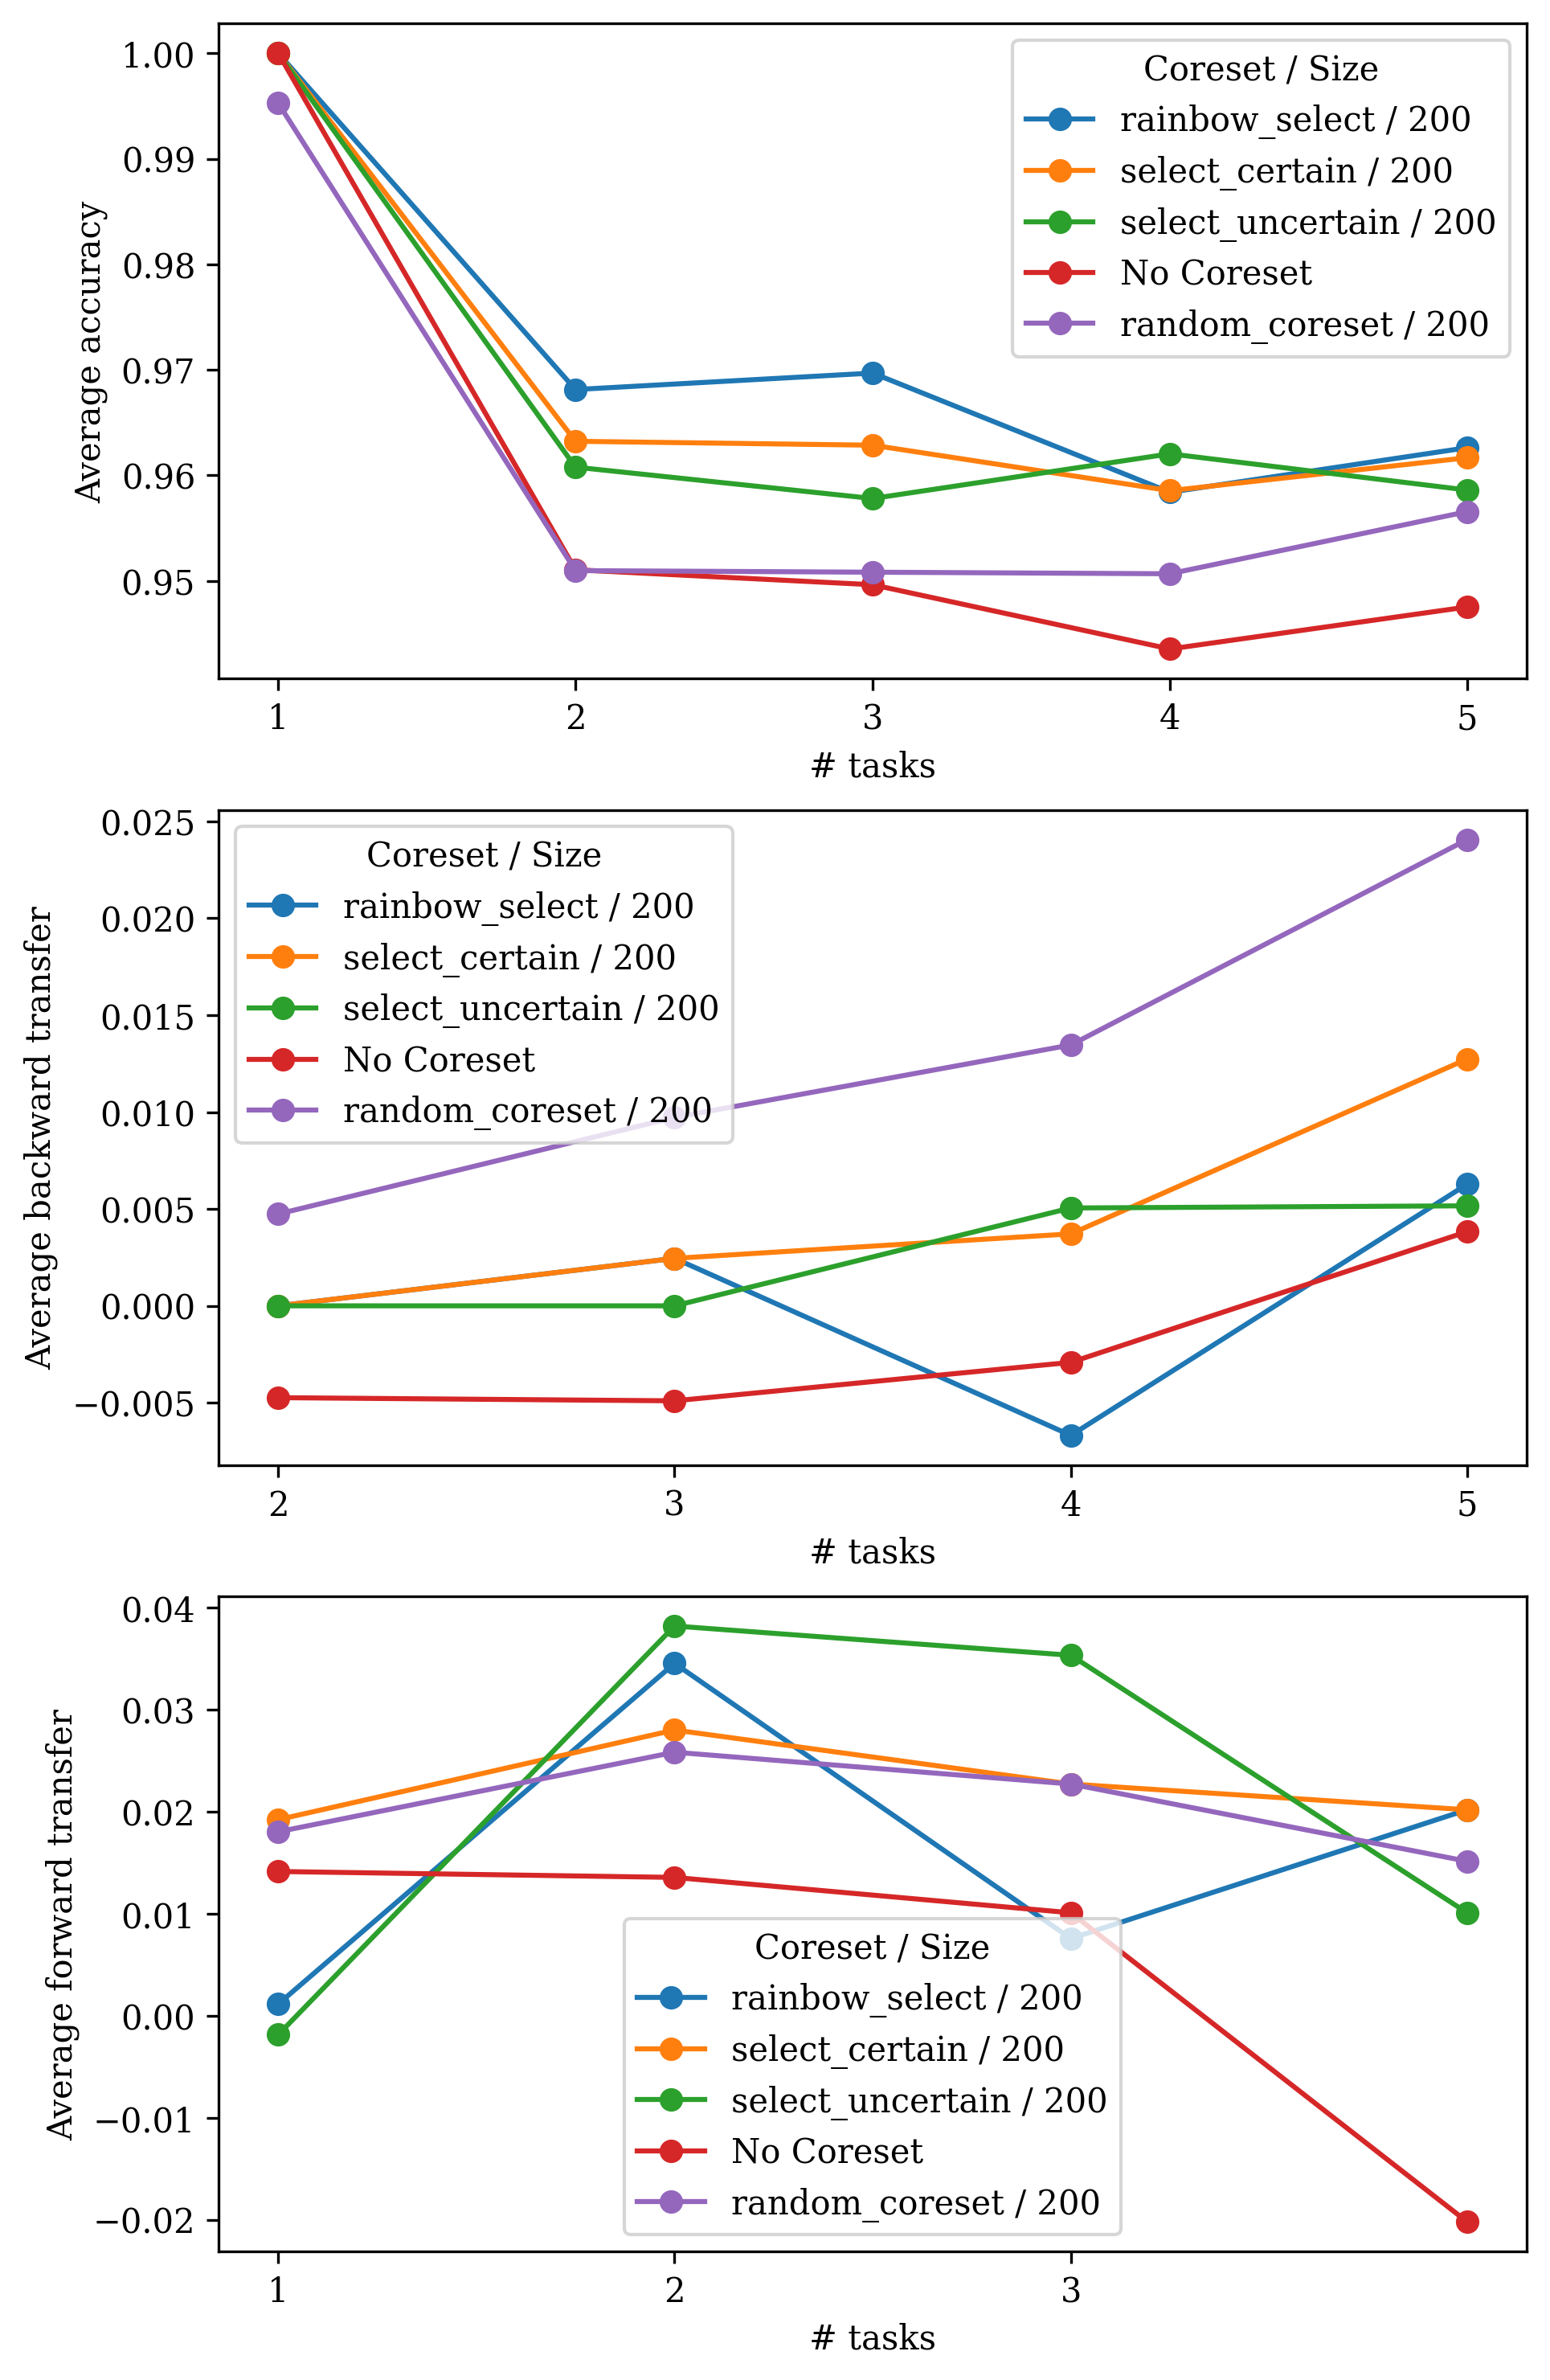

In [ ]:
num_epochs = 30
batch_size = 256
coresets = [(rainbow_select, 200), (select_certain, 200), (select_uncertain, 200), (None, 0), (random_coreset, 200)]
sample_ratio = 0.1
splitmnist_constant_KL_vary_memory(num_epochs=num_epochs, batch_size=batch_size, coresets=coresets, beta=1, sample_ratio=sample_ratio)

Beta: 1 with mean KL Divergence Constant KL Divergence
Sampling 1266 samples out of 12665 for training on task [0, 1]
Sampling 211 samples out of 2115 for testing on task [0, 1]
Sampling 1208 samples out of 12089 for training on task [2, 3]
Sampling 204 samples out of 2042 for testing on task [2, 3]
Sampling 1126 samples out of 11263 for training on task [4, 5]
Sampling 187 samples out of 1874 for testing on task [4, 5]
Sampling 1218 samples out of 12183 for training on task [6, 7]
Sampling 198 samples out of 1986 for testing on task [6, 7]
Sampling 1180 samples out of 11800 for training on task [8, 9]
Sampling 198 samples out of 1983 for testing on task [8, 9]
Model Arch:
 SplitModel(
  (fc1): BBBLinear()
  (fc2): BBBLinear()
  (classifiers): ModuleList(
    (0-4): 5 x BBBLinear()
  )
)
Accuracies of the model without training: [0.45971564 0.58823529 0.63101604 0.62626263 0.51010101]

Experimenting method: rainbow_select with coreset size 200
Starting Task 1
Dummy model achieves accur

100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 13.97it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.5637254901960784
Task 3 Accuracy: 0.5989304812834224
Task 4 Accuracy: 0.5858585858585859
Task 5 Accuracy: 0.51010101010101

Starting Task 2
Dummy model achieves accuracy 0.8652173913043478
task_indices: tensor([   5,    7,   10,  ..., 6063, 6069, 6071])

class: 0
Sampling 97 / 200 samples for class 0

class: 1
Sampling 103 / 200 samples for class 1
Selected a coreset with a average certainty in the dummy model of 0.827479898929596
          compared to 0.7661310434341431 in the whole dataset and 0.7539587020874023 in the non-core dataset


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 13.99it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 13.98it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.8627450980392157
Task 3 Accuracy: 0.5721925133689839
Task 4 Accuracy: 0.6212121212121212
Task 5 Accuracy: 0.51010101010101

Starting Task 3
Dummy model achieves accuracy 0.8623621323529411
task_indices: tensor([   0,    2,    9,  ..., 5934, 5936, 5939])

class: 0
Sampling 109 / 200 samples for class 0

class: 1
Sampling 91 / 200 samples for class 1
Selected a coreset with a average certainty in the dummy model of 0.8097456693649292
          compared to 0.7400141954421997 in the whole dataset and 0.7249534130096436 in the non-core dataset


100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 14.44it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 14.29it/s]


Replaying Task 3


100%|██████████| 10/10 [00:00<00:00, 13.98it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.8872549019607843
Task 3 Accuracy: 0.9197860962566845
Task 4 Accuracy: 0.5656565656565656
Task 5 Accuracy: 0.51010101010101

Starting Task 4
Dummy model achieves accuracy 0.9259423324742269
task_indices: tensor([  13,   15,   18,  ..., 5802, 5804, 5810])

class: 0
Sampling 95 / 200 samples for class 0

class: 1
Sampling 105 / 200 samples for class 1
Selected a coreset with a average certainty in the dummy model of 0.8558093309402466
          compared to 0.839419960975647 in the whole dataset and 0.8361999988555908 in the non-core dataset


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 14.19it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 14.17it/s]


Replaying Task 3


100%|██████████| 10/10 [00:00<00:00, 13.80it/s]


Replaying Task 4


100%|██████████| 10/10 [00:00<00:00, 14.15it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.8872549019607843
Task 3 Accuracy: 0.9197860962566845
Task 4 Accuracy: 0.9747474747474747
Task 5 Accuracy: 0.51010101010101

Starting Task 5
Dummy model achieves accuracy 0.8601762820512822
task_indices: tensor([   4,   17,   19,  ..., 6145, 6149, 6152])

class: 0
Sampling 95 / 200 samples for class 0

class: 1
Sampling 105 / 200 samples for class 1
Selected a coreset with a average certainty in the dummy model of 0.7931706309318542
          compared to 0.7040296792984009 in the whole dataset and 0.6858376860618591 in the non-core dataset


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 13.96it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 13.92it/s]


Replaying Task 3


100%|██████████| 10/10 [00:00<00:00, 13.85it/s]


Replaying Task 4


100%|██████████| 10/10 [00:00<00:00, 14.15it/s]


Replaying Task 5


100%|██████████| 10/10 [00:00<00:00, 14.21it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.8921568627450981
Task 3 Accuracy: 0.9197860962566845
Task 4 Accuracy: 0.9747474747474747
Task 5 Accuracy: 0.8939393939393939

[[1.         0.56372549 0.59893048 0.58585859 0.51010101]
 [1.         0.8627451  0.57219251 0.62121212 0.51010101]
 [1.         0.8872549  0.9197861  0.56565657 0.51010101]
 [1.         0.8872549  0.9197861  0.97474747 0.51010101]
 [1.         0.89215686 0.9197861  0.97474747 0.89393939]]
Average accuracy on already trained tasks after each task: [1.         0.93137255 0.93568033 0.94544712 0.93612597]
Average backward transfer after each task: [0.         0.0122549  0.00816993 0.00735294]
Average forward transfer after each task: [-0.02424985 -0.02129134 -0.03030303  0.        ]

Experimenting method: select_certain with coreset size 200
Starting Task 1
Dummy model achieves accuracy 0.9592261904761905
task_indices: tensor([ 366, 1930, 5052,  ..., 5635, 3882, 3247])

class: 0
Sampling 92 / 200 samples for class 0

class: 

100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 14.15it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.6176470588235294
Task 3 Accuracy: 0.5828877005347594
Task 4 Accuracy: 0.6161616161616161
Task 5 Accuracy: 0.51010101010101

Starting Task 2
Dummy model achieves accuracy 0.860546875
task_indices: tensor([1351, 5588,   76,  ..., 3381, 5259, 1249])

class: 0
Sampling 97 / 200 samples for class 0

class: 1
Sampling 103 / 200 samples for class 1
Selected a coreset with a average certainty in the dummy model of 0.993452787399292
          compared to 0.7670217752456665 in the whole dataset and 0.7109744548797607 in the non-core dataset


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 14.33it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 13.81it/s]


Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.8676470588235294
Task 3 Accuracy: 0.5989304812834224
Task 4 Accuracy: 0.5656565656565656
Task 5 Accuracy: 0.51010101010101

Starting Task 3
Dummy model achieves accuracy 0.8917746242088608
task_indices: tensor([1810, 2646, 1705, 3624, 2542,  692, 4038, 1037,  614, 1477,  531, 3184,
        2329, 3595, 3071, 3437, 1482, 1991, 4177, 2279, 5064,  244,  100, 2478,
        1604, 2753, 2091, 4752,  768,  916, 3484, 5764, 2965, 4174, 2596,  899,
         652,  914, 2281, 4205, 5158, 1524,  906, 4386, 4641, 4197, 2809, 3356,
        1721, 5180, 5406, 5198,  894, 1468,  775, 3666, 5134, 5066,  407, 4178,
        2490,  332,  886, 1580, 5303, 1481, 5719,  842, 3681,  127, 4146, 1887,
        5157,   35, 3668, 1514, 1575, 2832, 2416, 5378, 4558, 1970, 1215, 5309,
        1813, 2290, 3219, 1298,  897,  420, 3724, 1275,   61, 5188, 4135, 3039,
        4538, 1690, 4004, 4885, 3637, 3732, 2589, 4728, 4102, 5177, 3608, 5936,
         719, 3450, 143

100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 13.78it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 14.27it/s]


Replaying Task 3


100%|██████████| 10/10 [00:00<00:00, 14.30it/s]


Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.8970588235294118
Task 3 Accuracy: 0.8877005347593583
Task 4 Accuracy: 0.5707070707070707
Task 5 Accuracy: 0.51010101010101

Starting Task 4
Dummy model achieves accuracy 0.933171875
task_indices: tensor([2055, 3229, 3985,  ..., 3249, 3749,  534])

class: 0
Sampling 94 / 200 samples for class 0

class: 1
Sampling 106 / 200 samples for class 1
Selected a coreset with a average certainty in the dummy model of 0.9961912035942078
          compared to 0.8415412306785583 in the whole dataset and 0.8037294745445251 in the non-core dataset


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 14.12it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 14.26it/s]


Replaying Task 3


100%|██████████| 10/10 [00:00<00:00, 14.33it/s]


Replaying Task 4


100%|██████████| 10/10 [00:00<00:00, 14.18it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.8921568627450981
Task 3 Accuracy: 0.893048128342246
Task 4 Accuracy: 0.9696969696969697
Task 5 Accuracy: 0.51010101010101

Starting Task 5
Dummy model achieves accuracy 0.8567954009433962
task_indices: tensor([4947, 5940, 5008, 2815, 3256,  460,  532, 5893, 3104, 5725, 2793,  793,
        5625, 3173, 5943, 5518,  125, 2425, 3284, 4350, 1893, 4456, 1221, 5136,
        3446, 1783, 4797, 2331, 3594,  687, 3664, 2378, 1457, 1383, 5577,  418,
         602, 2555, 4788, 4006, 3991, 3090, 6041, 1591, 4652, 2465, 5800, 4092,
         539, 4677, 3055, 1161, 2787, 2649, 3959, 1732, 4305, 5430, 3636, 3818,
        4929, 2026, 4606, 1780, 3316, 2699, 4816, 5727, 3382, 3094, 1912, 4383,
        3918, 2678, 3866, 1364, 1598, 5369, 3759, 1484, 1254, 1453, 4147, 4040,
        1683, 4547, 6030, 3152,  925, 1101, 4381,  280, 5670,  812, 1344, 2421,
        5024, 1500, 1585, 1026, 2613, 3662, 5522, 1005, 3616, 4894, 5645, 4215,
        1239, 2382, 3935, 2140, 5376, 

100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 14.35it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 14.09it/s]


Replaying Task 3


100%|██████████| 10/10 [00:00<00:00, 13.87it/s]


Replaying Task 4


100%|██████████| 10/10 [00:00<00:00, 14.15it/s]


Replaying Task 5


100%|██████████| 10/10 [00:00<00:00, 14.13it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.8872549019607843
Task 3 Accuracy: 0.8983957219251337
Task 4 Accuracy: 0.9747474747474747
Task 5 Accuracy: 0.9040404040404041

[[1.         0.61764706 0.5828877  0.61616162 0.51010101]
 [0.99526066 0.86764706 0.59893048 0.56565657 0.51010101]
 [0.99526066 0.89705882 0.88770053 0.57070707 0.51010101]
 [1.         0.89215686 0.89304813 0.96969697 0.51010101]
 [1.         0.8872549  0.89839572 0.97474747 0.9040404 ]]
Average accuracy on already trained tasks after each task: [1.         0.93145386 0.92667334 0.93872549 0.9328877 ]
Average backward transfer after each task: [-0.00473934  0.01233621  0.00995247  0.00883838]
Average forward transfer after each task: [-0.0072044  -0.03089721 -0.02777778  0.        ]

Experimenting method: select_uncertain with coreset size 200
Starting Task 1
Dummy model achieves accuracy 0.9624521683673469
task_indices: tensor([1697,   99, 5245, 5876, 1600,  345, 3809, 4763, 3811, 2663, 5425, 2890,
        4009, 5983, 3

100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 14.21it/s]


Task 1 Accuracy: 0.981042654028436
Task 2 Accuracy: 0.6127450980392157
Task 3 Accuracy: 0.5775401069518716
Task 4 Accuracy: 0.5555555555555556
Task 5 Accuracy: 0.51010101010101

Starting Task 2
Dummy model achieves accuracy 0.873828125
task_indices: tensor([3557,  642, 5104, 4755, 2332, 4446,  549, 2531,  684, 1881, 5031, 1241,
         327, 1246, 4864, 5841, 4792,  844, 4341, 5907, 5812, 4011, 2357, 3176,
        1249, 5162, 2669, 2585, 3383, 2847, 1151, 4697, 1201, 3005, 1348, 3472,
        4843, 2309,  199, 4646, 4474, 1213, 1255, 2735, 5941,  574, 4570,    5,
        3813,  555, 5706, 2915, 4238,   27, 2342, 3934, 4733,  866, 1299, 4742,
        1021,   82, 1185, 2580, 5207,  433, 3147, 4510, 4111,  262, 2738, 1315,
        5080, 1651, 1385, 3124, 3596, 5241, 1264, 4276, 3395, 3054, 4157, 2960,
        4212, 1588,  863,  767, 1295,   28, 1108, 3824, 2205,  187, 5193, 5919,
        5642, 5770,  233, 1675,  659, 4442, 5659,  931, 4086, 1077, 1883, 3553,
        5736, 4154, 4204, 2812

100%|██████████| 10/10 [00:02<00:00,  4.70it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 14.05it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 14.18it/s]


Task 1 Accuracy: 0.990521327014218
Task 2 Accuracy: 0.7843137254901961
Task 3 Accuracy: 0.5989304812834224
Task 4 Accuracy: 0.6313131313131313
Task 5 Accuracy: 0.51010101010101

Starting Task 3
Dummy model achieves accuracy 0.8694265965732088
task_indices: tensor([5303, 2893,  438, 4174,  100, 1110, 2416, 3922, 5499, 2248, 4462,  244,
        1030, 3416, 4195, 2052, 2596, 5198, 1934, 1288, 4757,  502, 2569,  363,
        4645, 4781, 5719, 4297, 2165, 3056, 1911, 1587,  655, 2131, 4746, 2646,
        4562, 1613, 2109, 3025, 1885,  372, 1767,    2, 2698, 3275, 4847, 5356,
        1541, 3450,  834, 5032, 4194, 3129,  605, 4327, 2965, 2737,  480, 2566,
        1537, 3761, 5526, 1818, 1667, 2406, 1379, 4197, 5061,  523, 5265, 2157,
        4017, 5490, 1433, 3496,  496, 2290, 4097, 1180, 2330, 1813, 3125, 4703,
         754, 1111, 4252, 5211, 2874, 5060, 5550,  847, 3203, 2900, 3558, 1847,
        5847,  191, 2560,  335, 1955, 5771, 4382, 3126, 3535, 2254, 2651, 2240,
        2441, 1922,  61

100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 14.01it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 14.24it/s]


Replaying Task 3


100%|██████████| 10/10 [00:00<00:00, 14.15it/s]


Task 1 Accuracy: 0.995260663507109
Task 2 Accuracy: 0.8382352941176471
Task 3 Accuracy: 0.8770053475935828
Task 4 Accuracy: 0.5959595959595959
Task 5 Accuracy: 0.51010101010101

Starting Task 4
Dummy model achieves accuracy 0.937265625
task_indices: tensor([3599, 4131, 4560, 5253, 5003, 1582,   15, 1159,  933, 5466,  973, 3808,
        2658, 5448, 3856, 4572,  599,  644, 2657,  431, 3268, 2242, 3577, 1353,
        2750, 3428, 5786, 2925, 3451, 3994, 1389, 4934, 1335,  701,  261,  640,
        2575,  939, 2296, 3814, 2701, 4227, 2156, 5326, 2054, 3654, 5035, 5676,
         536, 4643,  686,  617, 5329, 3633, 3952, 2992, 4155,  908,  948, 4478,
        1186, 5473, 4526, 5561,  301, 4672, 1957, 4061, 3255, 5347, 5214, 4832,
        3252, 4211, 5535, 1146, 1656, 1297, 3405, 1958, 3507, 1891, 1982, 5213,
        2486, 5302, 1166, 3579, 4458, 2059, 1919,  436, 4130, 1057, 4759, 2027,
        1821, 5721,  759, 2704,  421, 1562, 1113, 4943, 3559, 1416, 1619, 5182,
        5267, 3058, 4799,  977

100%|██████████| 10/10 [00:02<00:00,  4.68it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 13.83it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 13.94it/s]


Replaying Task 3


100%|██████████| 10/10 [00:00<00:00, 13.68it/s]


Replaying Task 4


100%|██████████| 10/10 [00:00<00:00, 14.02it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.8431372549019608
Task 3 Accuracy: 0.9197860962566845
Task 4 Accuracy: 0.9444444444444444
Task 5 Accuracy: 0.51010101010101

Starting Task 5
Dummy model achieves accuracy 0.8619791666666666
task_indices: tensor([5521, 2702, 5522, 5539, 1173, 4032, 2349, 2150, 2679, 6051, 4277, 5476,
        5628, 3303, 4860, 5544, 2216, 3742, 3786, 3476, 3760, 3663,  831, 2555,
        5853, 3636, 5030,  641, 5548, 1758, 3865, 5430, 3164, 4652, 3152, 1056,
          57,  226, 4100, 5775, 4609,  133, 4345, 1856, 1598, 4684, 5116,  796,
        2139, 5391, 5165, 3499, 2378, 2787, 6111, 3168, 2302,  441, 4307, 2682,
        1901, 3555,  812, 3495,  940, 4368,  319, 5783,  312, 2860, 3069, 3027,
        5695, 2124,  362,  428, 2140, 4831, 3912, 4275, 3055,  858, 1396, 3365,
         631, 5142, 4117, 5087, 3785, 4982, 4678,  755, 4063, 4973, 5558, 5836,
        1426, 3935, 5376, 4215,  348, 1339,  280, 4448,  826, 3032, 2951, 5034,
         550, 3144, 2394, 2453, 1025,

100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 14.42it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 14.29it/s]


Replaying Task 3


100%|██████████| 10/10 [00:00<00:00, 14.23it/s]


Replaying Task 4


100%|██████████| 10/10 [00:00<00:00, 14.24it/s]


Replaying Task 5


100%|██████████| 10/10 [00:00<00:00, 14.26it/s]


Task 1 Accuracy: 0.990521327014218
Task 2 Accuracy: 0.8137254901960784
Task 3 Accuracy: 0.8983957219251337
Task 4 Accuracy: 0.9595959595959596
Task 5 Accuracy: 0.9040404040404041

[[0.98104265 0.6127451  0.57754011 0.55555556 0.51010101]
 [0.99052133 0.78431373 0.59893048 0.63131313 0.51010101]
 [0.99526066 0.83823529 0.87700535 0.5959596  0.51010101]
 [1.         0.84313725 0.9197861  0.94444444 0.51010101]
 [0.99052133 0.81372549 0.89839572 0.95959596 0.9040404 ]]
Average accuracy on already trained tasks after each task: [0.98104265 0.88741753 0.90350044 0.92684195 0.91325578]
Average backward transfer after each task: [0.00947867 0.03406979 0.04018721 0.01885808]
Average forward transfer after each task: [-0.0249183  -0.00901169 -0.01515152  0.        ]

Experimenting method: None with coreset size 0
Starting Task 1


100%|██████████| 10/10 [00:02<00:00,  4.53it/s]


Done Training Task 1

Task 1 Accuracy: 0.990521327014218
Task 2 Accuracy: 0.5931372549019608
Task 3 Accuracy: 0.5454545454545454
Task 4 Accuracy: 0.5454545454545454
Task 5 Accuracy: 0.51010101010101

Starting Task 2


100%|██████████| 10/10 [00:02<00:00,  4.63it/s]


Done Training Task 2

Task 1 Accuracy: 0.976303317535545
Task 2 Accuracy: 0.8676470588235294
Task 3 Accuracy: 0.5775401069518716
Task 4 Accuracy: 0.6111111111111112
Task 5 Accuracy: 0.51010101010101

Starting Task 3


100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


Done Training Task 3

Task 1 Accuracy: 0.985781990521327
Task 2 Accuracy: 0.8480392156862745
Task 3 Accuracy: 0.8449197860962567
Task 4 Accuracy: 0.6161616161616161
Task 5 Accuracy: 0.51010101010101

Starting Task 4


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


Done Training Task 4

Task 1 Accuracy: 0.981042654028436
Task 2 Accuracy: 0.8480392156862745
Task 3 Accuracy: 0.893048128342246
Task 4 Accuracy: 0.9545454545454546
Task 5 Accuracy: 0.51010101010101

Starting Task 5


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Done Training Task 5

Task 1 Accuracy: 0.985781990521327
Task 2 Accuracy: 0.8676470588235294
Task 3 Accuracy: 0.893048128342246
Task 4 Accuracy: 0.9696969696969697
Task 5 Accuracy: 0.7777777777777778

[[0.99052133 0.59313725 0.54545455 0.54545455 0.51010101]
 [0.97630332 0.86764706 0.57754011 0.61111111 0.51010101]
 [0.98578199 0.84803922 0.84491979 0.61616162 0.51010101]
 [0.98104265 0.84803922 0.89304813 0.95454545 0.51010101]
 [0.98578199 0.86764706 0.89304813 0.96969697 0.77777778]]
Average accuracy on already trained tasks after each task: [0.99052133 0.92197519 0.89291366 0.91916886 0.89879039]
Average backward transfer after each task: [-0.01421801 -0.01217359  0.00634728  0.01463513]
Average forward transfer after each task: [-0.0403669  -0.02287582 -0.00505051  0.        ]

Experimenting method: random_coreset with coreset size 200
Starting Task 1


100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


Done Training Task 1

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 14.13it/s]


Task 1 Accuracy: 0.976303317535545
Task 2 Accuracy: 0.5735294117647058
Task 3 Accuracy: 0.5775401069518716
Task 4 Accuracy: 0.5606060606060606
Task 5 Accuracy: 0.51010101010101

Starting Task 2


100%|██████████| 10/10 [00:01<00:00,  6.96it/s]


Done Training Task 2

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 14.28it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 14.33it/s]


Task 1 Accuracy: 0.985781990521327
Task 2 Accuracy: 0.8186274509803921
Task 3 Accuracy: 0.5935828877005348
Task 4 Accuracy: 0.5707070707070707
Task 5 Accuracy: 0.51010101010101

Starting Task 3


100%|██████████| 10/10 [00:01<00:00,  7.80it/s]


Done Training Task 3

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 14.12it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 14.36it/s]


Replaying Task 3


100%|██████████| 10/10 [00:00<00:00, 14.48it/s]


Task 1 Accuracy: 0.990521327014218
Task 2 Accuracy: 0.8382352941176471
Task 3 Accuracy: 0.8556149732620321
Task 4 Accuracy: 0.6262626262626263
Task 5 Accuracy: 0.51010101010101

Starting Task 4


100%|██████████| 10/10 [00:01<00:00,  6.90it/s]


Done Training Task 4

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 13.92it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 14.23it/s]


Replaying Task 3


100%|██████████| 10/10 [00:00<00:00, 14.08it/s]


Replaying Task 4


100%|██████████| 10/10 [00:00<00:00, 14.04it/s]


Task 1 Accuracy: 0.990521327014218
Task 2 Accuracy: 0.8774509803921569
Task 3 Accuracy: 0.8716577540106952
Task 4 Accuracy: 0.9393939393939394
Task 5 Accuracy: 0.51010101010101

Starting Task 5


100%|██████████| 10/10 [00:01<00:00,  7.17it/s]


Done Training Task 5

Replaying Task 1


100%|██████████| 10/10 [00:00<00:00, 14.13it/s]


Replaying Task 2


100%|██████████| 10/10 [00:00<00:00, 14.17it/s]


Replaying Task 3


100%|██████████| 10/10 [00:00<00:00, 14.04it/s]


Replaying Task 4


100%|██████████| 10/10 [00:00<00:00, 14.35it/s]


Replaying Task 5


100%|██████████| 10/10 [00:00<00:00, 14.19it/s]


Task 1 Accuracy: 1.0
Task 2 Accuracy: 0.8529411764705882
Task 3 Accuracy: 0.9037433155080213
Task 4 Accuracy: 0.9040404040404041
Task 5 Accuracy: 0.8181818181818182

[[0.97630332 0.57352941 0.57754011 0.56060606 0.51010101]
 [0.98578199 0.81862745 0.59358289 0.57070707 0.51010101]
 [0.99052133 0.83823529 0.85561497 0.62626263 0.51010101]
 [0.99052133 0.87745098 0.87165775 0.93939394 0.51010101]
 [1.         0.85294118 0.90374332 0.9040404  0.81818182]]
Average accuracy on already trained tasks after each task: [0.97630332 0.90220472 0.89479053 0.919756   0.89578134]
Average backward transfer after each task: [0.00947867 0.01691293 0.02969477 0.0176963 ]
Average forward transfer after each task: [-0.0334596  -0.03099624  0.          0.        ]


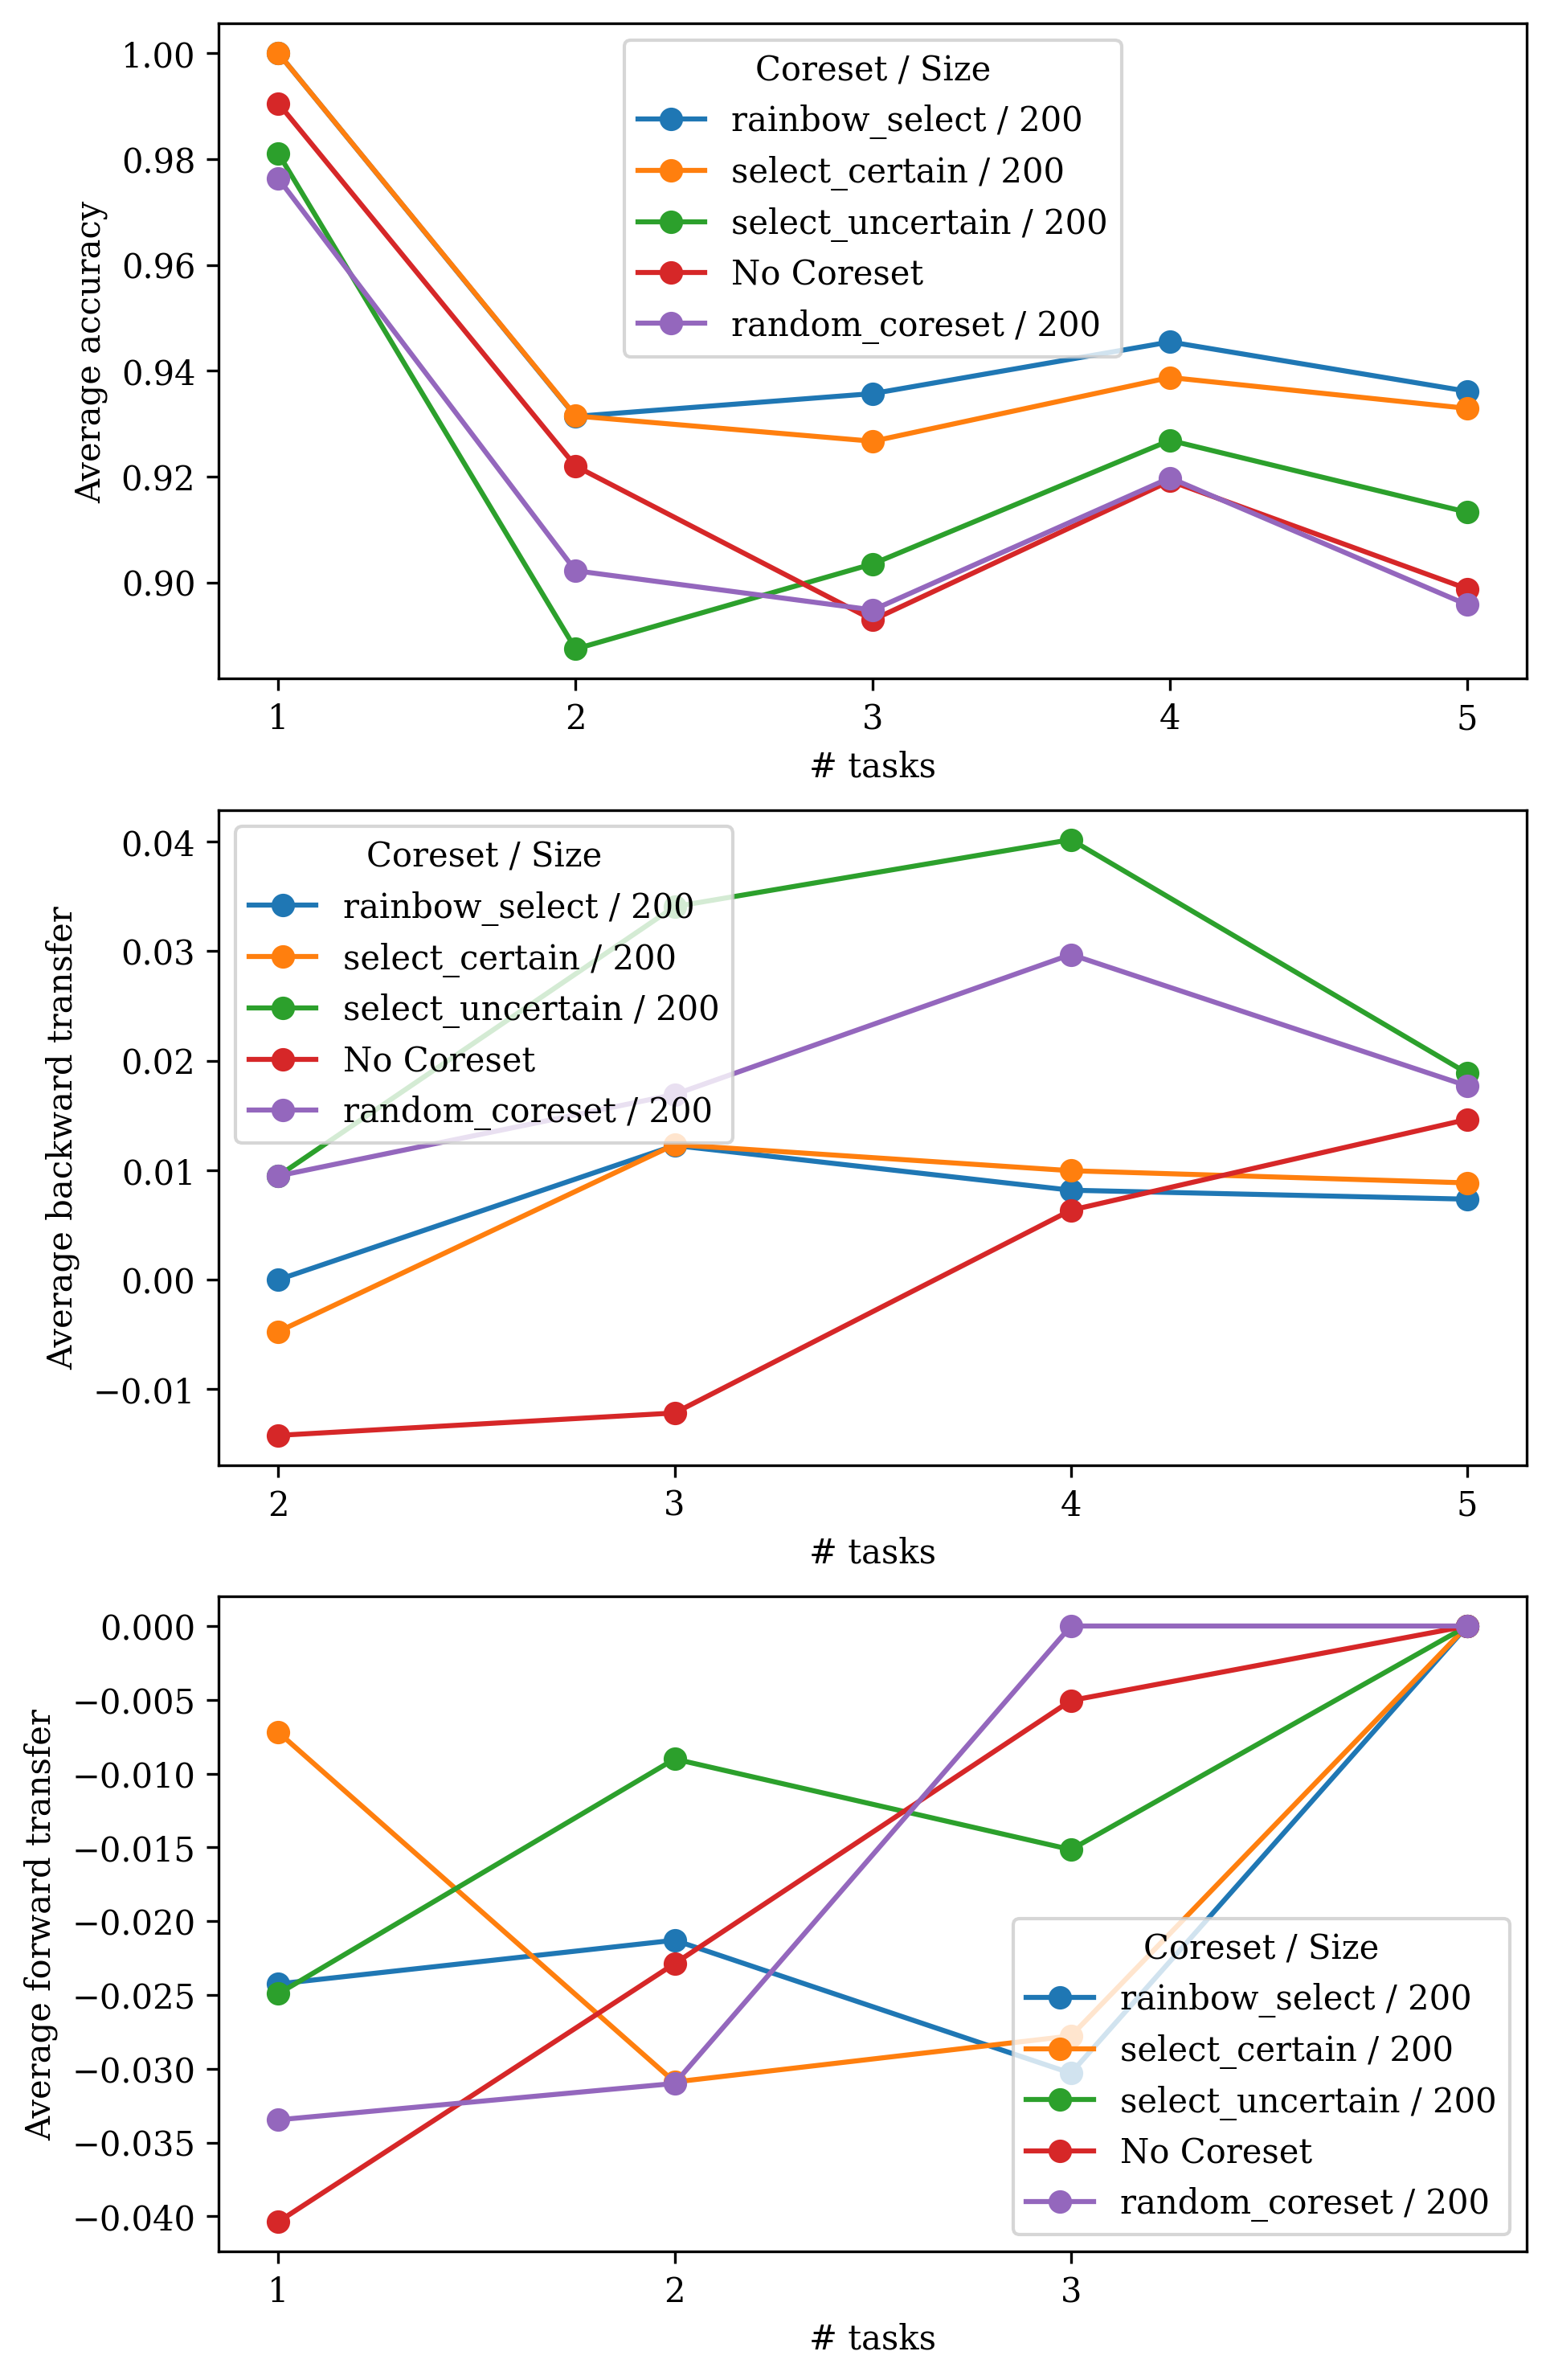

In [ ]:
num_epochs = 10
batch_size = 256
coresets = [(rainbow_select, 200), (select_certain, 200), (select_uncertain, 200), (None, 0), (random_coreset, 200)]
sample_ratio = 0.1
splitmnist_constant_KL_vary_memory(num_epochs=num_epochs, batch_size=batch_size, coresets=coresets, beta=1, sample_ratio=sample_ratio)